In [18]:
import xarray as xr
import pandas as pd
import progressbar
import numpy as np
from oggm.utils import mkdir
import matplotlib.pyplot as plt

In [19]:
%pwd

'/home/www/lschuster/runs/runs_diff_calib_protect'

### GCMs - missing glaciers overview 

In [20]:
dirpath = '/home/www/lschuster/runs_oggm_v16/runs_2023.3/output'
# # this path has changed to ''
# dirpath = '/home/www/oggm/oggm-standard-projections/oggm_v16/2023.3/'
# (but also some folder structures have changed,
# see http://localhost:7261/lab/tree/www_oggm/oggm-standard-projections/oggm-standard-projections-csv-files/notebooks/aggregate_csv_files_1.6.1.ipynb)

In [21]:
import os
allfiles = []
for root, dirs, files in os.walk(dirpath):
    for file in files:
        if (file.endswith(".nc")) and ('CMIP6' in file) and ('endyr2100' in file) and ('_0_1000' in file) and ('w5e5_gcm_merged' in file) and ('basin' not in file) and ('bc_2000_2019' in file):
             allfiles.append(os.path.join(root, file))

In [22]:
rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')

In [23]:
rgi_meta = rgi_meta.loc[rgi_meta.Connect != 2]

In [7]:
df_meta = pd.DataFrame()
invalid_per_reg = {}  
meta_per_reg = {}

In [9]:
exp = 'match_geod_pergla' #output_1.6.1_2023.3' 

invalid_per_reg = {}  
meta_per_reg = {}
for f in allfiles: #progressbar.progressbar(allfiles):
    ename = f.replace(dirpath, '')
    ss = ename.split('/')
    #exp = ss[0]
    rgi_reg = ss[1]
    gcm = ss[2].split('_')[7] #ss[2]
    ssp = ss[2].split('_')[8]
    
    end0,end1 = ss[2].split('_')[-2:]
    end = end0+'_'+end1
    ff = f[:-len(end)]+'*'
    if ssp not in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
        continue
    
    run_id = f'{exp}:{gcm}:{ssp}:{rgi_reg}'
    df_meta.loc[run_id, 'gcm'] = gcm
    df_meta.loc[run_id, 'ssp'] = ssp
    df_meta.loc[run_id, 'rgi_reg'] = rgi_reg
    df_meta.loc[run_id, 'end_year'] = 0
    df_meta.loc[run_id, 'perc_area_missing'] = 0
    df_meta.loc[run_id, 'fpath'] = ff
    
    if rgi_reg not in invalid_per_reg:
        invalid_per_reg[rgi_reg] = set()
    
    if rgi_reg not in meta_per_reg:
        meta_per_reg[rgi_reg] = rgi_meta.loc[rgi_meta['O1Region'] == rgi_reg[-2:]]
    
    with xr.open_mfdataset(ff) as ds:
        ds_t = ds.isel(time=-1).volume.load()
    df_meta.loc[run_id, 'end_year'] = int(ds_t.time)
    missing_ids = ds_t.rgi_id[ds_t.isnull()].data
    perc = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum() / meta_per_reg[rgi_reg]['Area'].sum() 
    df_meta.loc[run_id, 'perc_area_missing'] = perc
    invalid_per_reg[rgi_reg] = invalid_per_reg[rgi_reg].union(missing_ids)
    if f == allfiles[100]:
        print(f)
df_meta['exp'] = exp
df_meta['oggm_version'] = 'oggm_v1.6.1_2023.3'

/home/www/lschuster/runs_oggm_v16/runs_2023.3/output/RGI03/run_hydro_w5e5_gcm_merged_endyr2100_CMIP6_MRI-ESM2-0_ssp119_bc_2000_2019_rgi03_0_1000.nc


In [10]:
dds = df_meta.sort_values('perc_area_missing', ascending=False)
dds[dds['perc_area_missing'] > 0.05].rgi_reg.unique()

array(['RGI12'], dtype=object)

In [11]:
dds

gcm     ssp rgi_reg  \
match_geod_pergla:NorESM2-MM:ssp126:RGI12        NorESM2-MM  ssp126   RGI12   
match_geod_pergla:NorESM2-MM:ssp370:RGI12        NorESM2-MM  ssp370   RGI12   
match_geod_pergla:INM-CM5-0:ssp585:RGI12          INM-CM5-0  ssp585   RGI12   
match_geod_pergla:INM-CM5-0:ssp245:RGI12          INM-CM5-0  ssp245   RGI12   
match_geod_pergla:CESM2:ssp370:RGI12                  CESM2  ssp370   RGI12   
...                                                     ...     ...     ...   
match_geod_pergla:FGOALS-f3-L:ssp126:RGI07      FGOALS-f3-L  ssp126   RGI07   
match_geod_pergla:MPI-ESM1-2-HR:ssp126:RGI07  MPI-ESM1-2-HR  ssp126   RGI07   
match_geod_pergla:INM-CM4-8:ssp585:RGI07          INM-CM4-8  ssp585   RGI07   
match_geod_pergla:INM-CM5-0:ssp585:RGI07          INM-CM5-0  ssp585   RGI07   
match_geod_pergla:INM-CM5-0:ssp370:RGI07          INM-CM5-0  ssp370   RGI07   

                                              end_year  perc_area_missing  \
match_geod_pergla:NorESM2-MM:ssp126:RGI12       2100.0           0.120892   
match_geod_pergla:NorESM2-MM:ssp370:RGI12       2100.0           0.119339   
match_geod_pergla:INM-CM5-0:ssp585:RGI12        2100.0           0.119330   
match_geod_pergla:INM-CM5-0:ssp245:RGI12        2100.0           0.119330   
match_geod_pergla:CESM2:ssp370:RGI12            2100.0           0.119330   
...                                                ...                ...   
match_geod_pergla:FGOALS-f3-L:ssp126:RGI07      2100.0           0.000000   
match_geod_pergla:MPI-ESM1-2-HR:ssp126:RGI07    2100.0           0.000000   
match_geod_pergla:INM-CM4-8:ssp585:RGI07        2100.0           0.000000   
match_geod_pergla:INM-CM5-0:ssp585:RGI07        2100.0           0.000000   
match_geod_pergla:INM-CM5-0:ssp370:RGI07        2100.0           0.000000   

                                                                                          fpath  \
match_geod_pergla:NorESM2-MM:ssp126:RGI12     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:NorESM2-MM:ssp370:RGI12     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:INM-CM5-0:ssp585:RGI12      /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:INM-CM5-0:ssp245:RGI12      /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:CESM2:ssp370:RGI12          /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
...                                                                                         ...   
match_geod_pergla:FGOALS-f3-L:ssp126:RGI07    /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:MPI-ESM1-2-HR:ssp126:RGI07  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:INM-CM4-8:ssp585:RGI07      /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:INM-CM5-0:ssp585:RGI07      /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   
match_geod_pergla:INM-CM5-0:ssp370:RGI07      /home/www/lschuster/runs_oggm_v16/runs_2023.3/...   

                                                            exp  \
match_geod_pergla:NorESM2-MM:ssp126:RGI12     match_geod_pergla   
match_geod_pergla:NorESM2-MM:ssp370:RGI12     match_geod_pergla   
match_geod_pergla:INM-CM5-0:ssp585:RGI12      match_geod_pergla   
match_geod_pergla:INM-CM5-0:ssp245:RGI12      match_geod_pergla   
match_geod_pergla:CESM2:ssp370:RGI12          match_geod_pergla   
...                                                         ...   
match_geod_pergla:FGOALS-f3-L:ssp126:RGI07    match_geod_pergla   
match_geod_pergla:MPI-ESM1-2-HR:ssp126:RGI07  match_geod_pergla   
match_geod_pergla:INM-CM4-8:ssp585:RGI07      match_geod_pergla   
match_geod_pergla:INM-CM5-0:ssp585:RGI07      match_geod_pergla   
match_geod_pergla:INM-CM5-0:ssp370:RGI07      match_geod_pergla   

                                                    oggm_version  
match_geod_pergla:NorESM2-MM:ssp126:RGI12     oggm_v1.6.1_2023.3  
match_geod_pergla:NorESM2-MM:ssp370:RGI12     oggm_v1.

In [12]:
df_meta.to_csv('output_1.6.1_2023.3/agg/metadata.csv')

In [13]:
for k, v in invalid_per_reg.items():
    invalid_per_reg[k] = list(v)

In [14]:
import json

In [15]:
with open('output_1.6.1_2023.3/agg/rgi_ids_missing.json', 'w') as f:
    json.dump(invalid_per_reg, f)

In [16]:
odf = pd.DataFrame()
for rgi_reg, missing_ids in invalid_per_reg.items():
    odf.loc[rgi_reg, 'n_glaciers'] = len(meta_per_reg[rgi_reg])
    odf.loc[rgi_reg, 'n_missing_glaciers'] = len(missing_ids)
    odf.loc[rgi_reg, 'rgi_area'] = meta_per_reg[rgi_reg]['Area'].sum() 
    odf.loc[rgi_reg, 'missing_area'] = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum()
    odf.loc[rgi_reg, 'missing_perc'] = odf.loc[rgi_reg, 'missing_area'] / odf.loc[rgi_reg, 'rgi_area']
odf[['n_glaciers', 'n_missing_glaciers']] = odf[['n_glaciers', 'n_missing_glaciers']].astype(int)
odf

n_glaciers  n_missing_glaciers    rgi_area  missing_area  missing_perc
RGI09        1069                   4   51591.600        23.984      0.000465
RGI03        4556                  29  105110.642        14.098      0.000134
RGI10        5151                 163    2410.051        88.943      0.036905
RGI17       15908                  81   29429.080        47.355      0.001609
RGI04        7415                  18   40888.228         3.914      0.000096
RGI19        2752                 525  132867.219       249.362      0.001877
RGI13       54429                 289   49303.415        80.025      0.001623
RGI14       27988                  85   33568.298        10.911      0.000325
RGI07        1615                   0   33958.934         0.000      0.000000
RGI05       19306                 117   89717.066        21.012      0.000234
RGI16        2939                  11    2341.036         0.672      0.000287
RGI11        3927                  31    2092.146         1.074      0.000513
RGI02       18855                  70   14524.224         3.677      0.000253
RGI08        3417                  14    2949.103         0.936      0.000317
RGI06         568                   2   11059.700         0.350      0.000032
RGI15       13119                  33   14734.204        10.180      0.000691
RGI12        1888                 373    1306.992       158.005      0.120892
RGI18        3537                   1    1161.801         0.052      0.000045
RGI01       27108                  45   86725.053        11.424      0.000132

In [17]:
odf.to_csv('output_1.6.1_2023.3/agg/missing_region_overview.csv')
odf.to_html('output_1.6.1_2023.3/agg/missing_region_overview.html')

### GCMs - aggregation

In [25]:
base_dir = 'output_1.6.1_2023.3/agg/'
df_meta = pd.read_csv('output_1.6.1_2023.3/agg/metadata.csv')

In [26]:
df_meta.ssp.unique()

array(['ssp245', 'ssp370', 'ssp585', 'ssp126', 'ssp119'], dtype=object)

In [27]:
from oggm import utils

In [ ]:
for exp in df_meta.exp.unique():
    print(exp, flush=True)
    for rgi_reg in sorted(df_meta.rgi_reg.unique()): #progressbar.progressbar(
        for ssp in sorted(df_meta.ssp.unique()):
            df_meta_s = df_meta.loc[(df_meta.exp == exp) & (df_meta.rgi_reg == rgi_reg) & (df_meta.ssp == ssp)]
            odf_v = pd.DataFrame()
            odf_a = pd.DataFrame()
            ods = []
            gcms = []
            for i, s in df_meta_s.iterrows():
                with xr.open_mfdataset(s.fpath) as ds:
                    ds = ds[['volume', 'area']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                    #ds = ds[['volume', 'area', 'length']].load().isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                    odf_v[s.gcm] = ds.volume.sum(dim='rgi_id').to_series()
                    odf_a[s.gcm] = ds.area.sum(dim='rgi_id').to_series()
                    ods.append(ds)
                    gcms.append(s.gcm)
            ods = xr.concat(ods, 'gcm')
            utils.mkdir(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/')
            ods.mean(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_avg_{ssp}.nc')
            ods.std(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/all_gcm_std_{ssp}.nc')
            odir = base_dir + f'volume/{exp}/{rgi_reg}/'
            mkdir(odir)
            odf_v.to_csv(odir + f'{ssp}.csv')
            odir = base_dir + f'area/{exp}/{rgi_reg}/'
            mkdir(odir)
            odf_a.to_csv(odir + f'{ssp}.csv')

match_geod_pergla


In [29]:
df_meta

Unnamed: 0            gcm     ssp  \
0        match_geod_pergla:MRI-ESM2-0:ssp245:RGI09     MRI-ESM2-0  ssp245   
1     match_geod_pergla:MPI-ESM1-2-HR:ssp370:RGI09  MPI-ESM1-2-HR  ssp370   
2         match_geod_pergla:GFDL-ESM4:ssp585:RGI09      GFDL-ESM4  ssp585   
3     match_geod_pergla:EC-Earth3-Veg:ssp585:RGI09  EC-Earth3-Veg  ssp585   
4             match_geod_pergla:CESM2:ssp126:RGI09          CESM2  ssp126   
...                                            ...            ...     ...   
1116    match_geod_pergla:CESM2-WACCM:ssp585:RGI01    CESM2-WACCM  ssp585   
1117      match_geod_pergla:EC-Earth3:ssp370:RGI01      EC-Earth3  ssp370   
1118    match_geod_pergla:CAMS-CSM1-0:ssp585:RGI01    CAMS-CSM1-0  ssp585   
1119    match_geod_pergla:FGOALS-f3-L:ssp370:RGI01    FGOALS-f3-L  ssp370   
1120    match_geod_pergla:BCC-CSM2-MR:ssp370:RGI01    BCC-CSM2-MR  ssp370   

     rgi_reg  end_year  perc_area_missing  \
0      RGI09    2100.0           0.000383   
1      RGI09    2100.0           0.000383   
2      RGI09    2100.0           0.000383   
3      RGI09    2100.0           0.000383   
4      RGI09    2100.0           0.000383   
...      ...       ...                ...   
1116   RGI01    2100.0           0.000130   
1117   RGI01    2100.0           0.000132   
1118   RGI01    2100.0           0.000132   
1119   RGI01    2100.0           0.000132   
1120   RGI01    2100.0           0.000132   

                                                  fpath                exp  \
0     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
1     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
2     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
3     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
4     /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
...                                                 ...                ...   
1116  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
1117  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
1118  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
1119  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   
1120  /home/www/lschuster/runs_oggm_v16/runs_2023.3/...  match_geod_pergla   

            oggm_version  
0     oggm_v1.6.1_2023.3  
1     oggm_v1.6.1_2023.3  
2     oggm_v1.6.1_2023.3  
3     oggm_v1.6.1_2023.3  
4     oggm_v1.6.1_2023.3  
...                  ...  
1116  oggm_v1.6.1_2023.3  
1117  oggm_v1.6.1_2023.3  
1118  oggm_v1.6.1_2023.3  
1119  oggm_v1.6.1_2023.3  
1120  oggm_v1.6.1_2023.3  

[1121 rows x 9 columns]

In [30]:
for var in ['volume', 'area']:
    for exp in df_meta.exp.unique():
        odir = base_dir + f'{var}/{exp}/global/'
        mkdir(odir)
        for ssp in sorted(df_meta.ssp.unique()):
            odf = 0
            for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                idir = base_dir + f'{var}/{exp}/{rgi_reg}/'
                df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
                odf += df
            odf.to_csv(odir + f'/{ssp}.csv')

**missing glaciers are filled with average glacier statistics from similar-area glaciers of that RGI region:**

In [31]:
fill = True
if fill:
    for exp in df_meta.exp.unique():
        print(exp, flush=True)
        for rgi_reg in sorted(df_meta.rgi_reg.unique()): #progressbar.progressbar(
            for ssp in sorted(df_meta.ssp.unique()):
                df_meta_s = df_meta.loc[(df_meta.exp == exp) & (df_meta.rgi_reg == rgi_reg) & (df_meta.ssp == ssp)]
                odf_v = pd.DataFrame()
                odf_a = pd.DataFrame()
                ods = []
                gcms = []
                for i, s in df_meta_s.iterrows():
                    with xr.open_mfdataset(s.fpath) as ds:
                        ds = ds[['volume', 'area']].load() # .isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))
                        ds_sel = ds.dropna(dim='rgi_id', how='all')
                        ds_sel = ds_sel.load()
                    rgi_reg_working = ds_sel.volume.isel(time=0).dropna(dim='rgi_id').rgi_id.values
                    rgi_meta_reg = rgi_meta.loc[rgi_meta['O1Region']==rgi_reg[3:]]
                    bad_rgi = list(set(rgi_meta_reg.index.values).difference(rgi_reg_working))

                    bad = rgi_meta_reg.loc[bad_rgi]  
                    good = rgi_meta_reg.loc[rgi_reg_working]  # working glaciers
                    bad_vs_total_ratio = bad.Area.sum() / (good.Area.sum() + bad.Area.sum())
                    if bad_vs_total_ratio >0.01:
                        print(rgi_reg, ssp, bad_vs_total_ratio)
                    #bad_glacier_count_perc = (len(bad)/len(good))
                    #print('Correcting for {:.2f}% bad area'.format(bad_ratio * 100))
                    assert len(bad)+len(good) == len(rgi_meta_reg.index)

                    # create dummy xarray dataset with empty data for the missing glaciers
                    # that will be filled afterwards
                    ds_dummy = ds_sel.isel(rgi_id=0).load().copy(deep=True)
                    ds_dummy['volume'].data[...] = np.NaN
                    ds_dummy['area'].data[...] = np.NaN
                    #ds_dummy = ds_dummy.drop('rgi_id')
                    #ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index}).transpose()
                    ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index.values}).transpose()
                    # NEW: also need to add the coords values -> maybe 
                    ds_dummy.coords['rgi_id'] = bad.index.values
                    # add the dummy xarray dataset to the existing glaciers
                    ds_sel_full = xr.concat([ds_sel, ds_dummy], dim='rgi_id')

                    # Repair the missing glaciers
                    ds_rep_sel = ds_sel_full.copy(deep=True)
                    ds_rep_sel = ds_rep_sel.squeeze()
                    ds_index = ds_rep_sel.rgi_id.data
                    # need to loop over every glacier 
                    for rid, g in bad.iterrows():
                        area_diff = np.abs(good.Area - g.Area) / g.Area
                        # if possible, take all glacers of that RGI region that 
                        # have a smaller relative area difference than 1 %
                        sel = area_diff.loc[area_diff < 0.01]
                        if len(sel) < 3:
                            # if less than 3 glaciers have a similar area,
                            # take instead the 9 area-most similar glaciers
                            sel = area_diff.sort_values().iloc[:9]
                        # Now, we take the average over the selected area-similar glaciers
                        # and add them as fake statistics for that missing glacier
                        # (in our case it is area and volume that  
                        # are estimated for each simulation year like that)
                        new = ds_sel.sel(rgi_id=sel.index).mean(dim='rgi_id').squeeze()
                        rep_id = np.nonzero(ds_index == rid)[0][0]
                        for vn in ds_rep_sel.data_vars:
                            ds_rep_sel[vn].data[...,rep_id] = new[vn].data
                            
                    odf_v[s.gcm] = ds_rep_sel.volume.sum(dim='rgi_id').to_series()
                    odf_a[s.gcm] = ds_rep_sel.area.sum(dim='rgi_id').to_series()
                    ods.append(ds)
                    gcms.append(s.gcm)
                ods = xr.concat(ods, 'gcm')
                utils.mkdir(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/')
                ods.mean(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/filled_all_gcm_avg_{ssp}.nc')
                ods.std(dim='gcm').to_netcdf(f'output_1.6.1_2023.3/{exp}/{rgi_reg}/filled_all_gcm_std_{ssp}.nc')
                odir = base_dir + f'volume/{exp}/{rgi_reg}/'
                mkdir(odir)
                odf_v.to_csv(odir + f'filled_{ssp}.csv')
                odir = base_dir + f'area/{exp}/{rgi_reg}/'
                mkdir(odir)
                odf_a.to_csv(odir + f'filled_{ssp}.csv')
                

match_geod_pergla
RGI10 ssp119 0.03668221128930466
RGI10 ssp119 0.0364809707346442
RGI10 ssp119 0.0364809707346442
RGI10 ssp119 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.036494248461962
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.03645109584817914
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.03660212999641915
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp126 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.036462298930603536
RGI10 ssp245 0.03650794111825849
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.036469767652219806
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.0364809707346442
RGI10 ssp245 0.

In [32]:
odir

'output_1.6.1_2023.3/agg/area/match_geod_pergla/RGI19/'

In [33]:
for var in ['volume', 'area']:
    for exp in df_meta.exp.unique():
        odir = base_dir + f'{var}/{exp}/global/'
        mkdir(odir)
        for ssp in sorted(df_meta.ssp.unique()):
            odf = 0
            for rgi_reg in sorted(df_meta.rgi_reg.unique()):
                idir = base_dir + f'{var}/{exp}/{rgi_reg}/'
                df = pd.read_csv(idir + f'/filled_{ssp}.csv', index_col=0)
                odf += df
            odf.to_csv(odir + f'/filled_{ssp}.csv')

## TO adapt: Compare unfilled, filled and previous OGGM-version

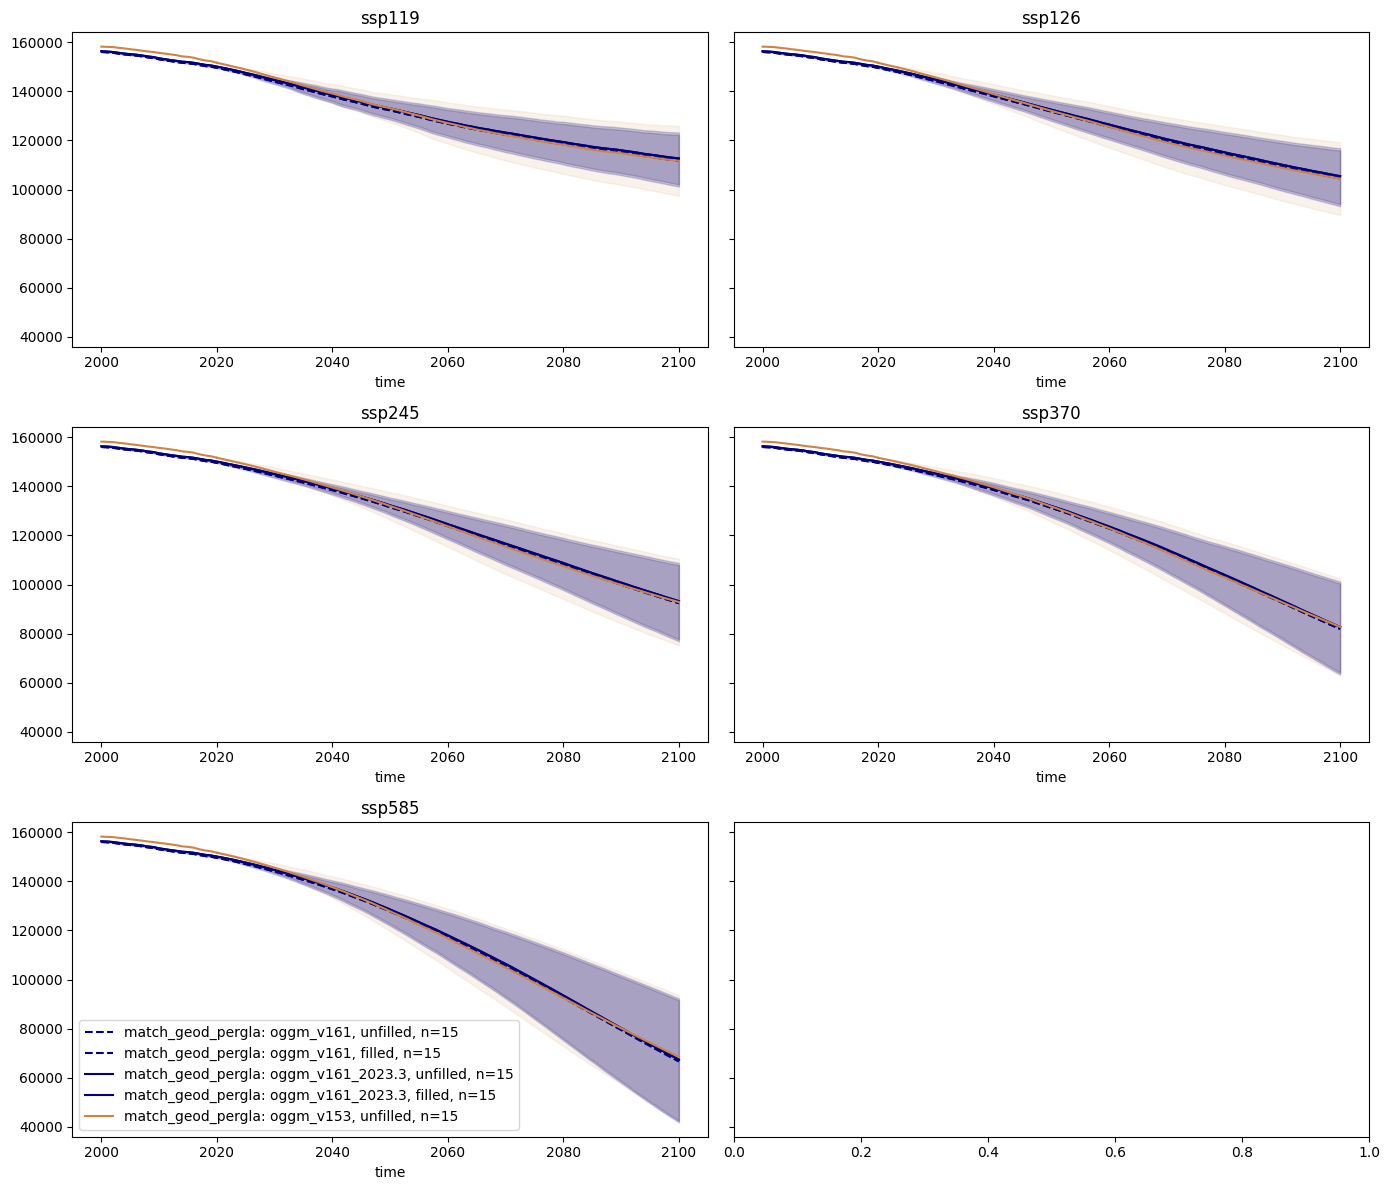

In [35]:
# global plot
f, axs = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axs = np.array(axs).flatten()
for ssp, ax in zip(sorted(df_meta.ssp.unique()), axs):
    for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
        for base_dir2,v in zip(['output_1.6.1/agg/', 'output_1.6.1_2023.3/agg/'],
                               ['', '_2023.3']):
            if v == '':
                ls = '--'
            else:
                ls = '-'
            idir = base_dir2 + f'volume/{exp}/global/'
            df = pd.read_csv(idir + f'{ssp}.csv', index_col=0)
            n = len(df.columns)
            avg = df.mean(axis=1) * 1e-9
            std = df.std(axis=1) * 1e-9
            ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color=c)
            avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, unfilled, n={n}', c=c, ls=ls);

            idir = base_dir2 + f'volume/{exp}/global/'
            df = pd.read_csv(idir + f'filled_{ssp}.csv', index_col=0)
            n_f = len(df.columns)
            avg = df.mean(axis=1) * 1e-9
            std = df.std(axis=1) * 1e-9
            ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color=c)
            avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, filled, n={n_f}', c=c, ls=ls);
        
        idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/agg/volume/{exp}/global'
        df = pd.read_csv(idir_oggm_v153 + f'/{ssp}.csv', index_col=0)
        n_v153 = len(df.columns)
        avg = df.mean(axis=1) * 1e-9
        std = df.std(axis=1) * 1e-9
        ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color='peru')
        avg.plot(ax=ax, label=f'{exp}: oggm_v153, unfilled, n={n_v153}', c='peru');

        idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/historical/agg/volume/{exp}/'
        df = pd.read_csv(idir_oggm_v153 + f'historical.csv', index_col=0).sum(axis=1).loc[2000:]
        avg = df * 1e-9
        #std = df.std(axis=1) * 1e-9
        #            x.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color='peru')
        avg.plot(ax=ax, c='peru', label=f'{exp}: oggm_v153');
    ax.set_title(ssp)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:-1], labels[:-1]);
plt.tight_layout();

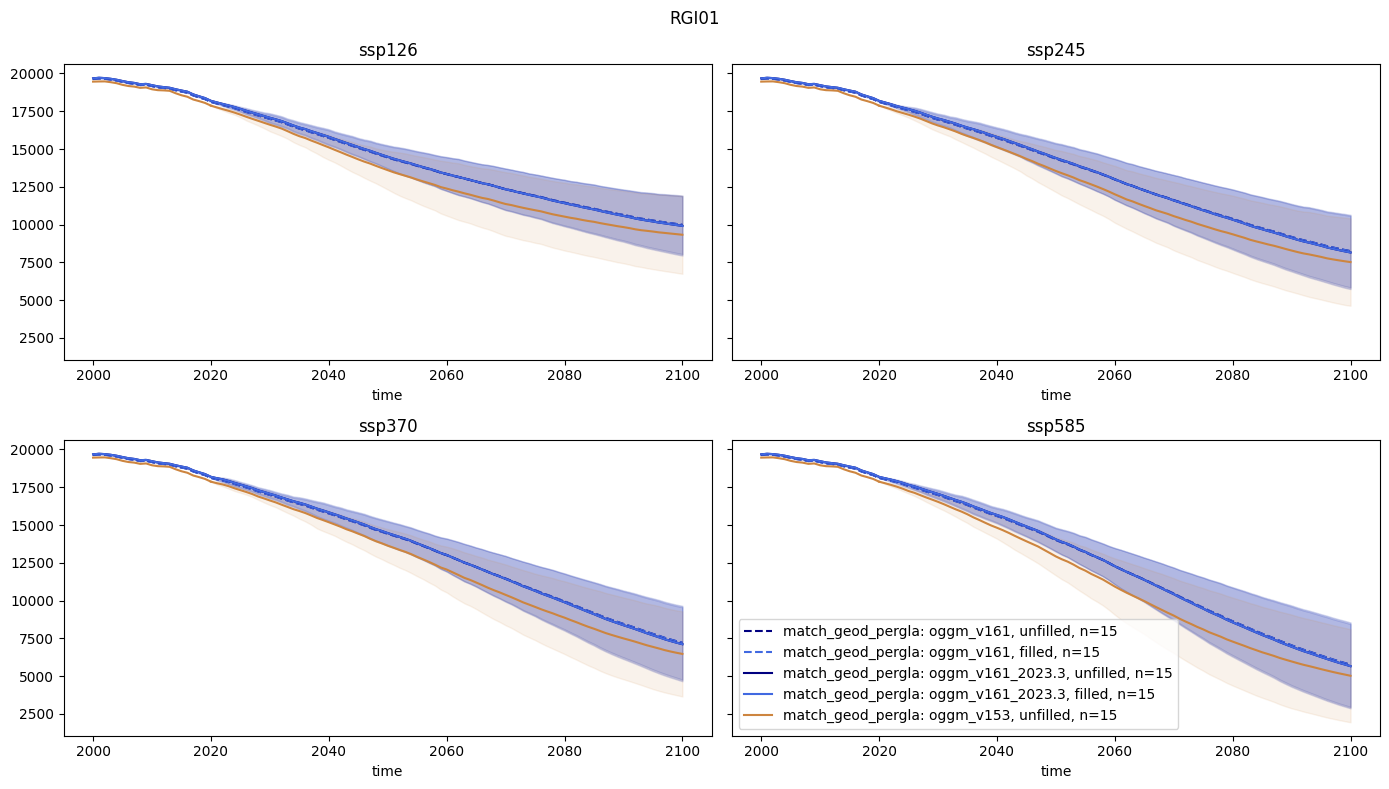

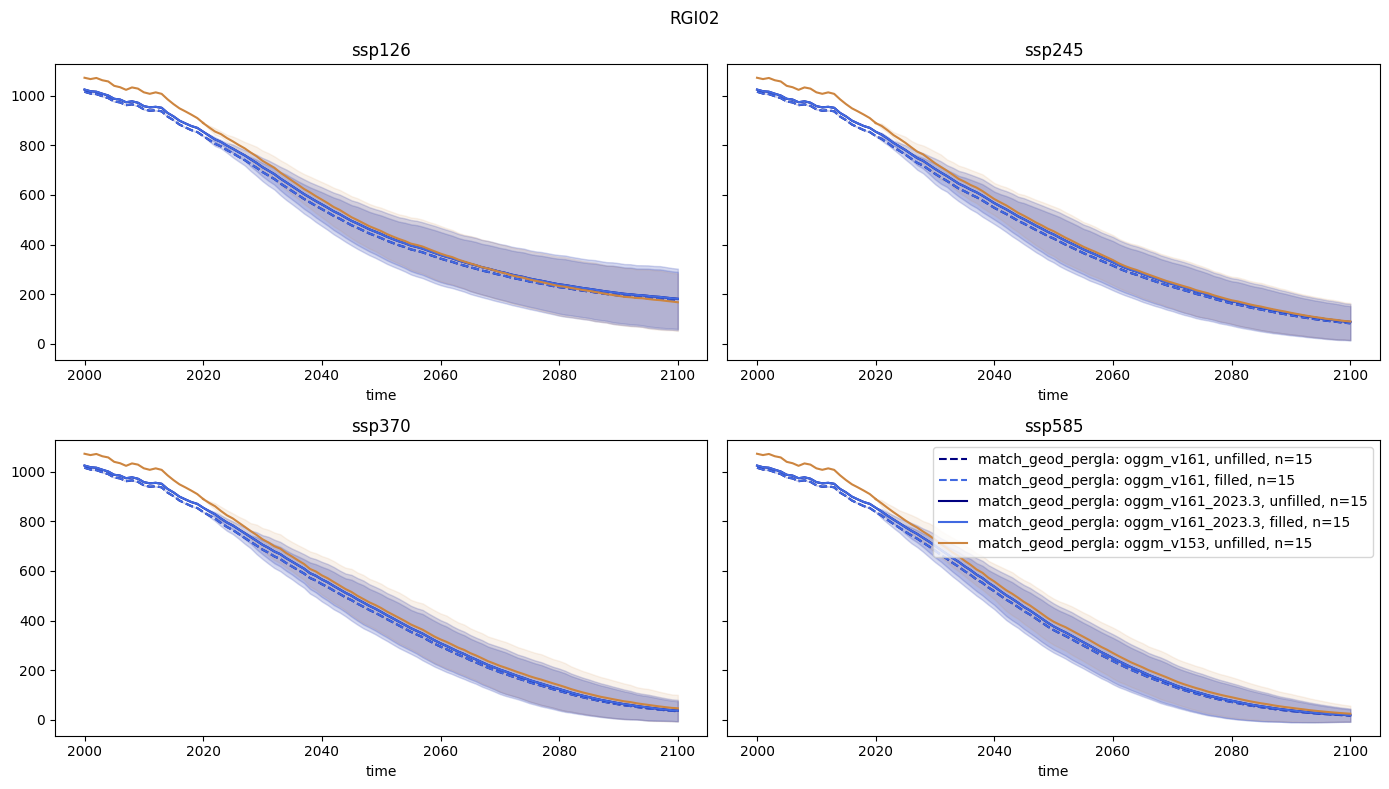

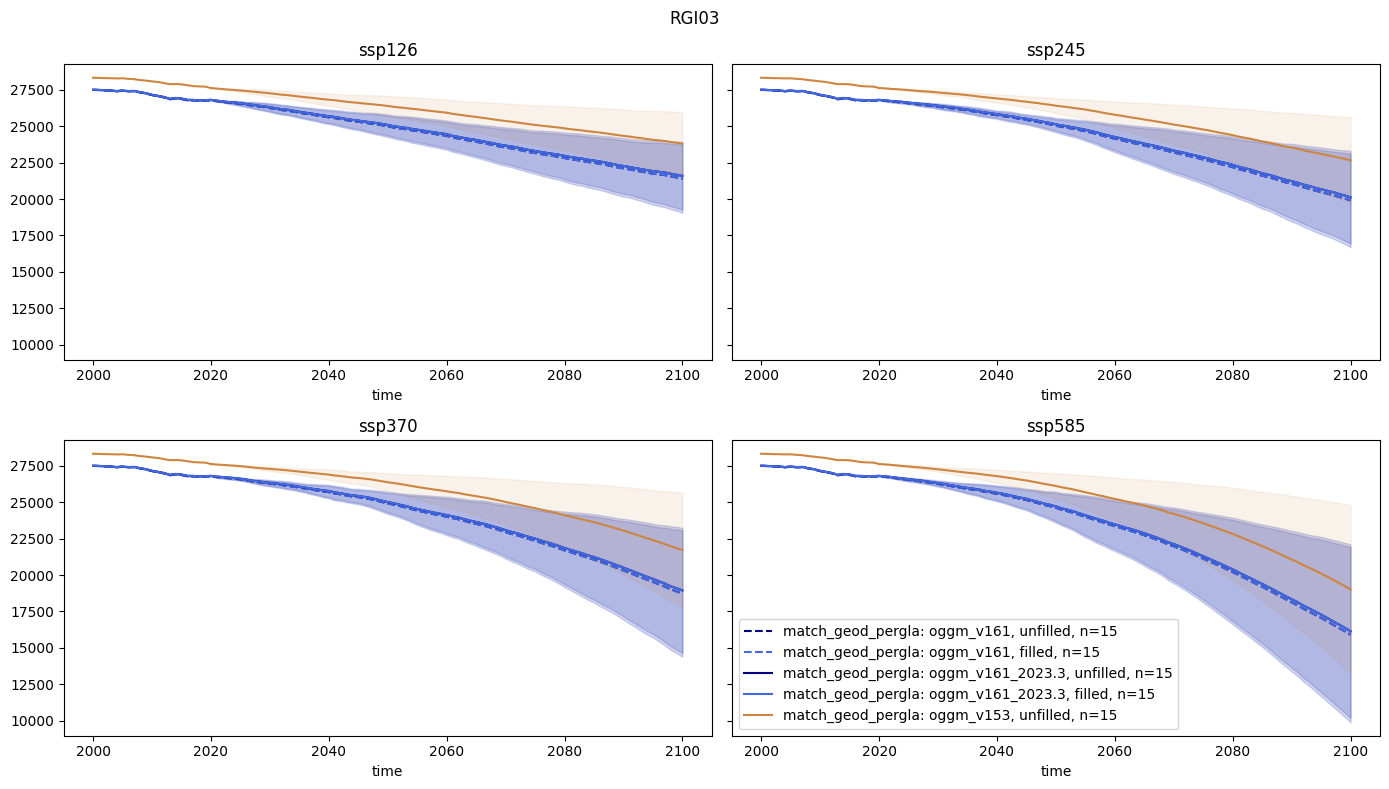

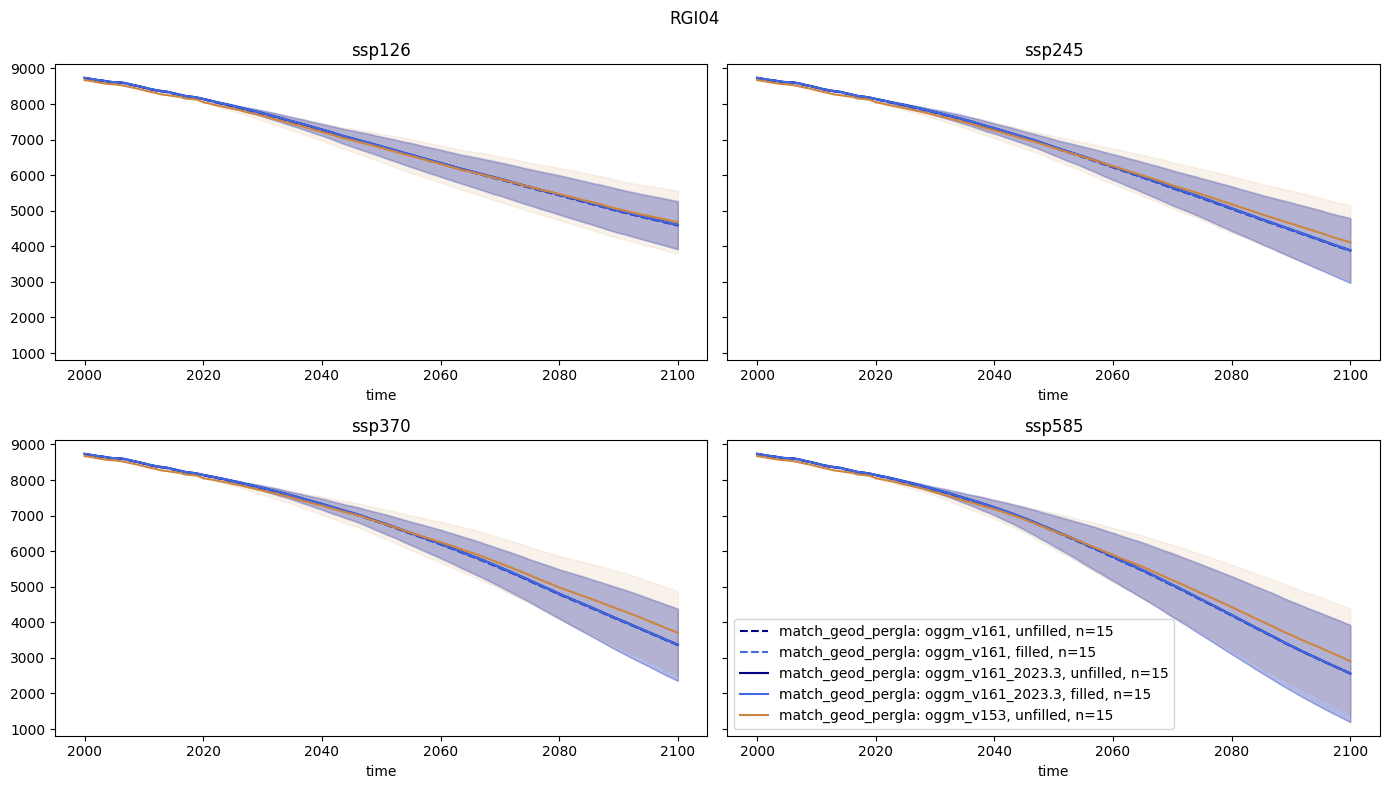

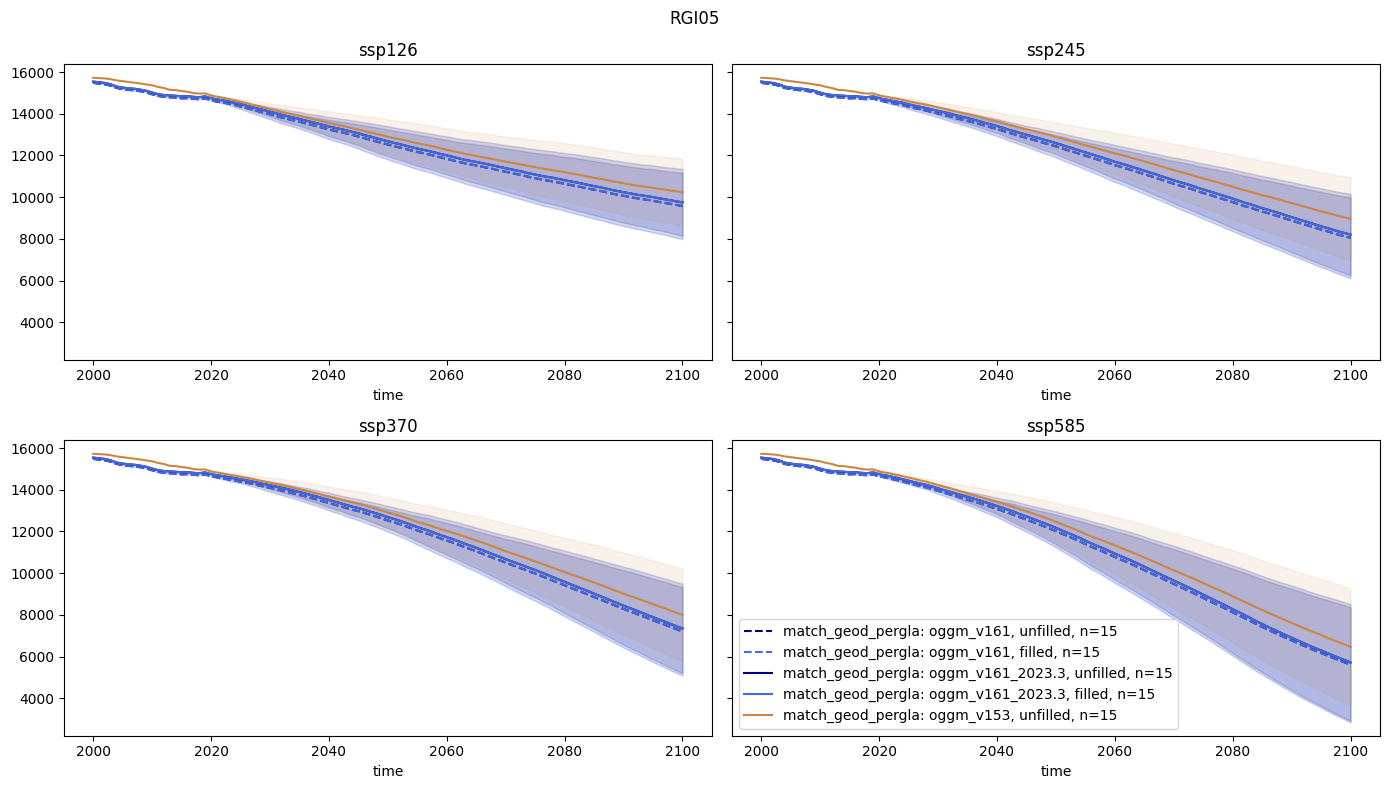

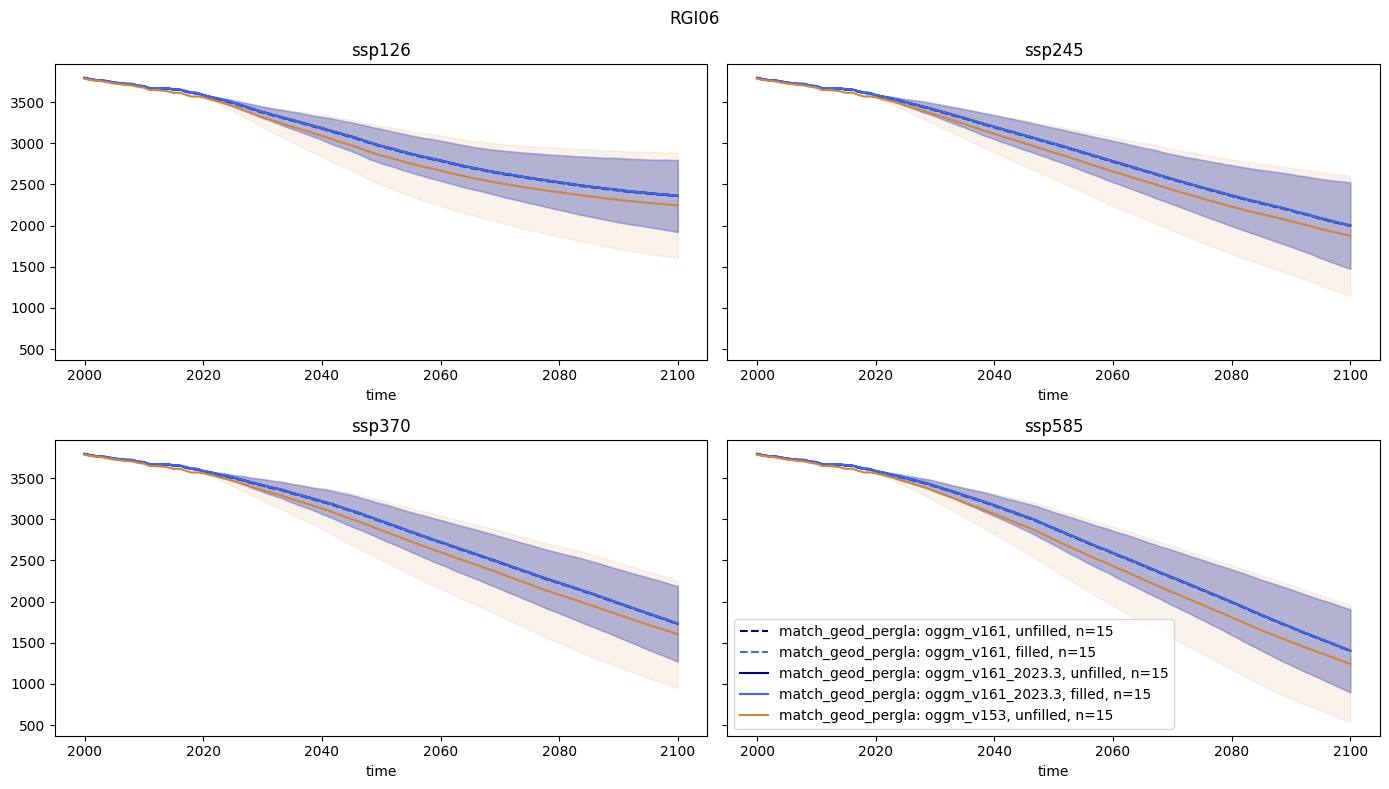

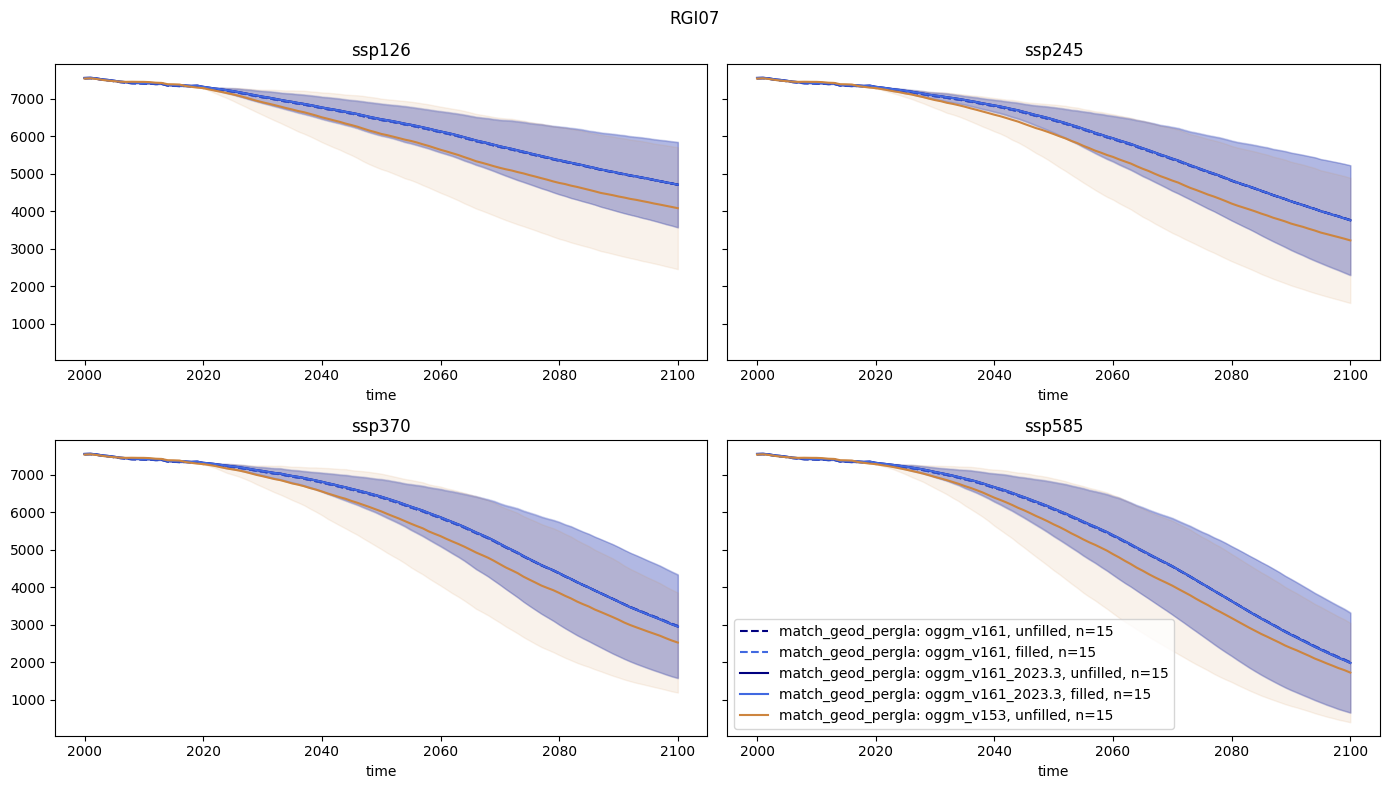

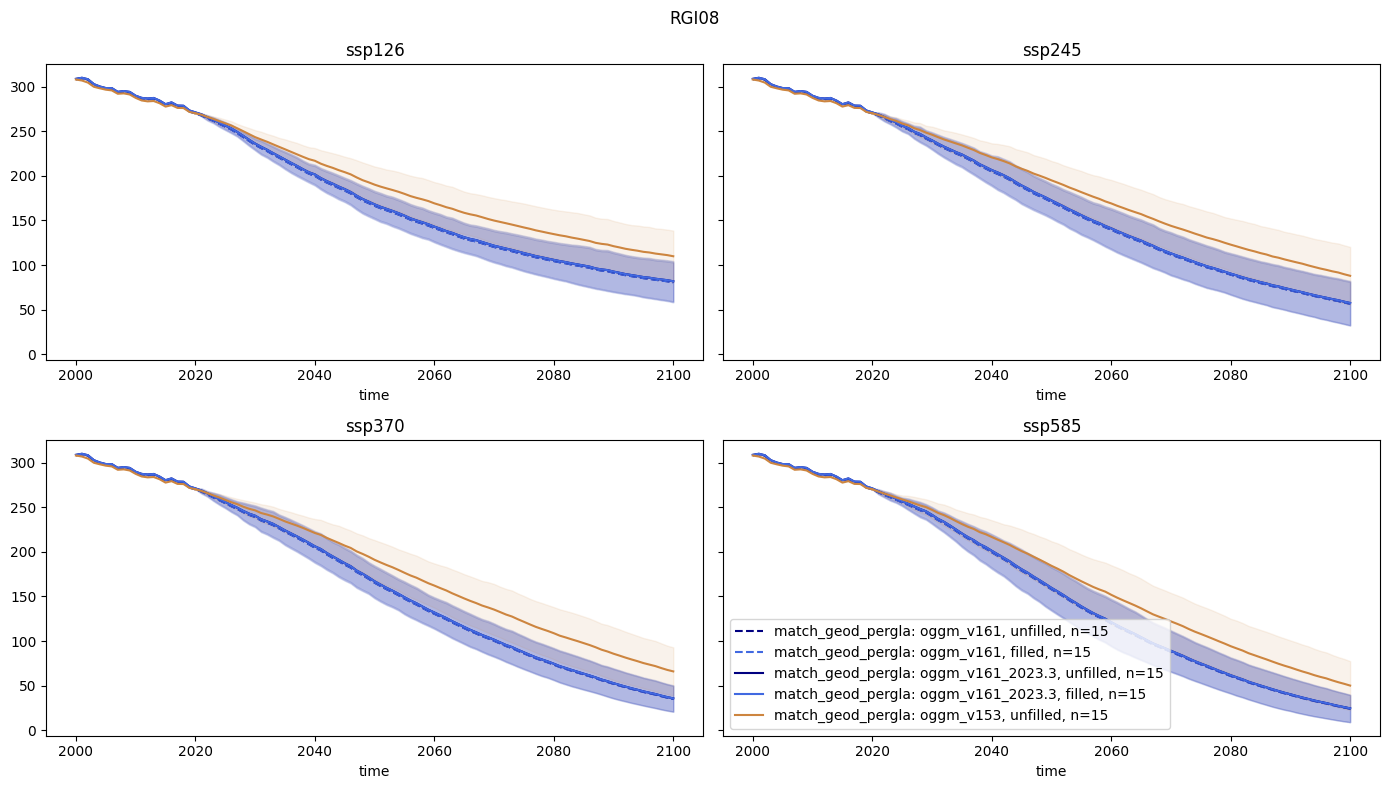

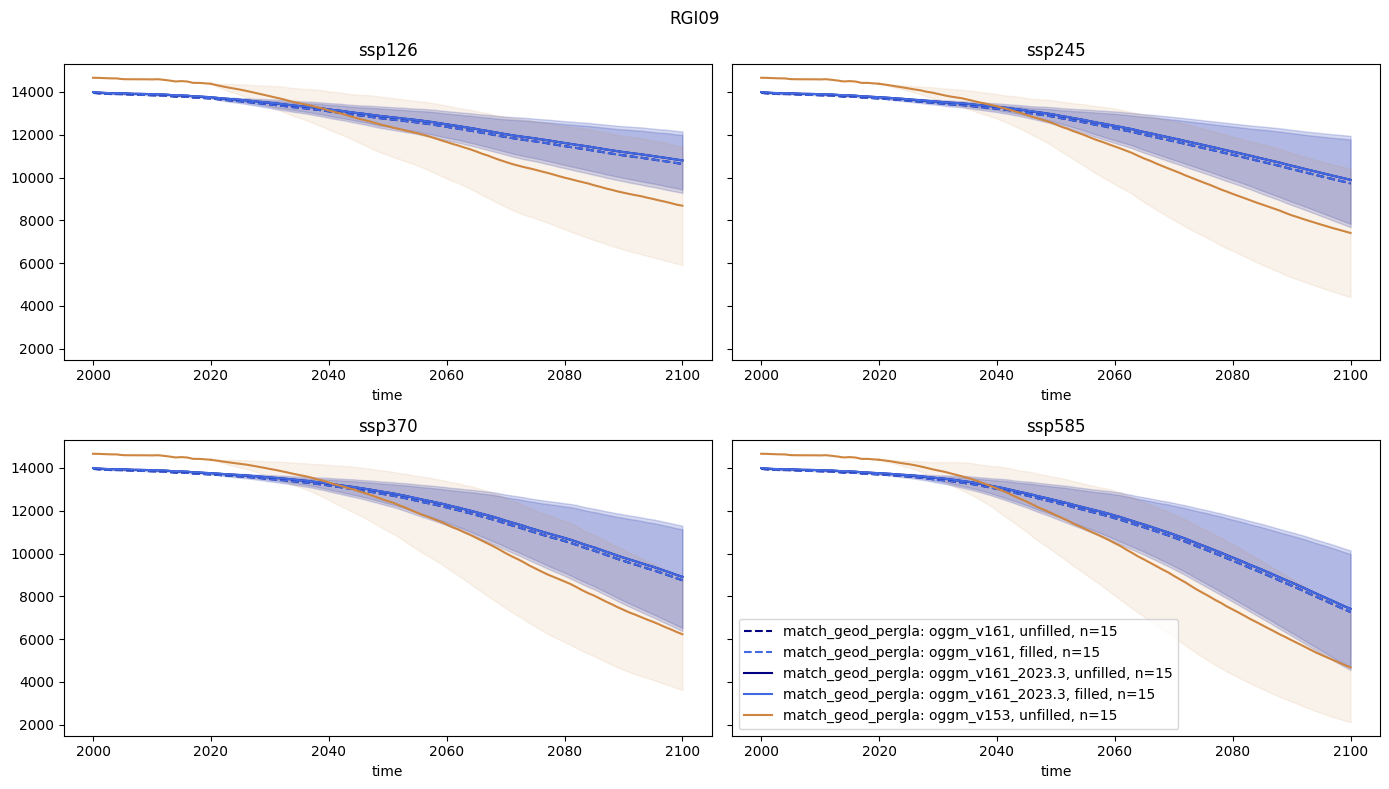

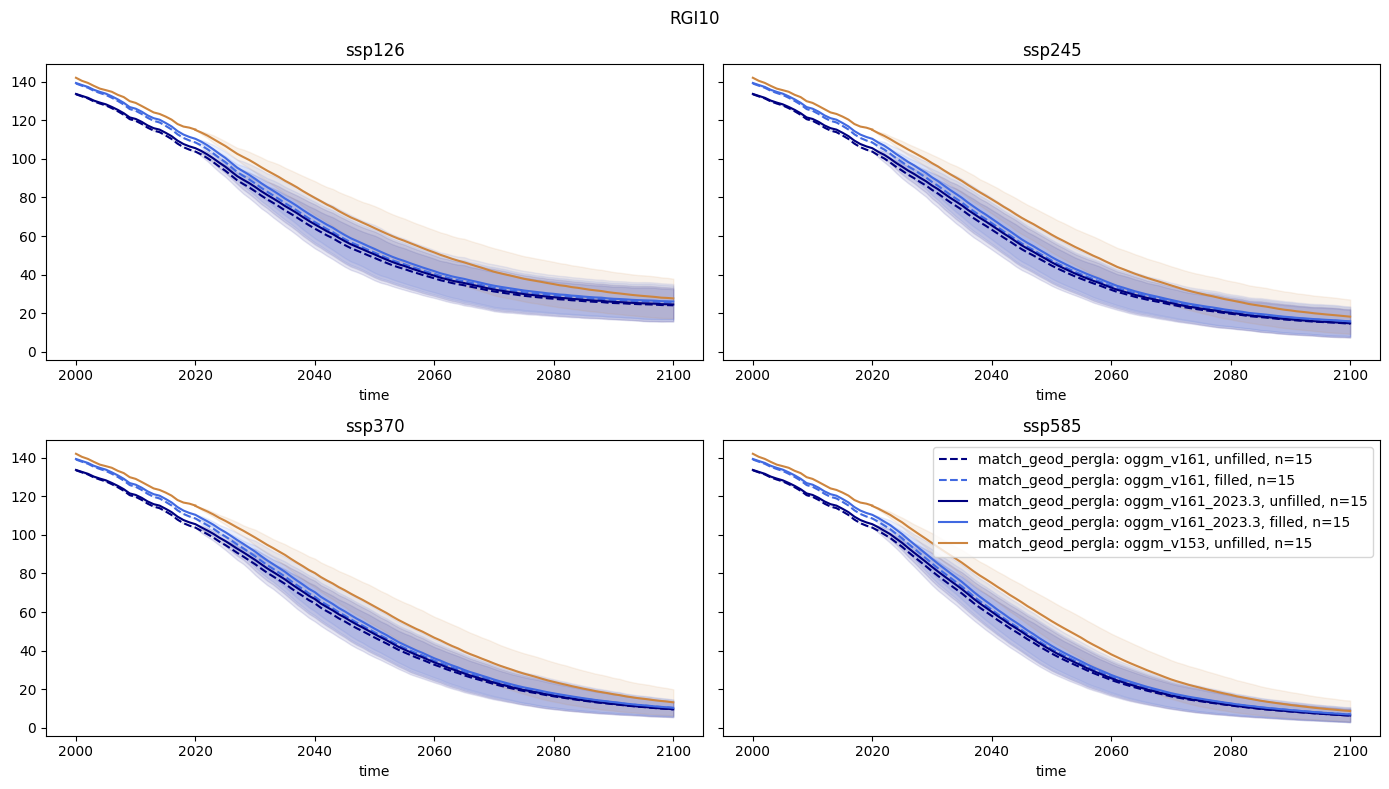

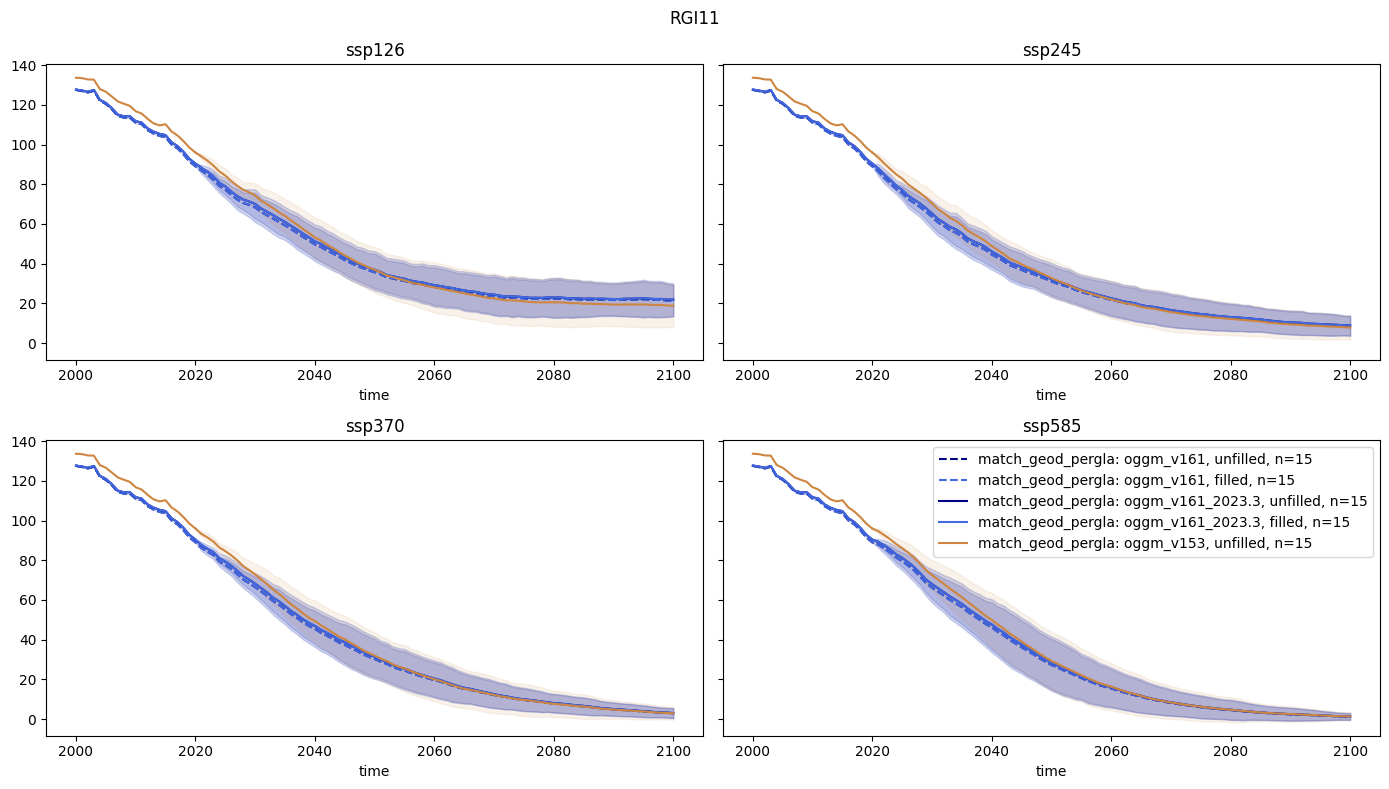

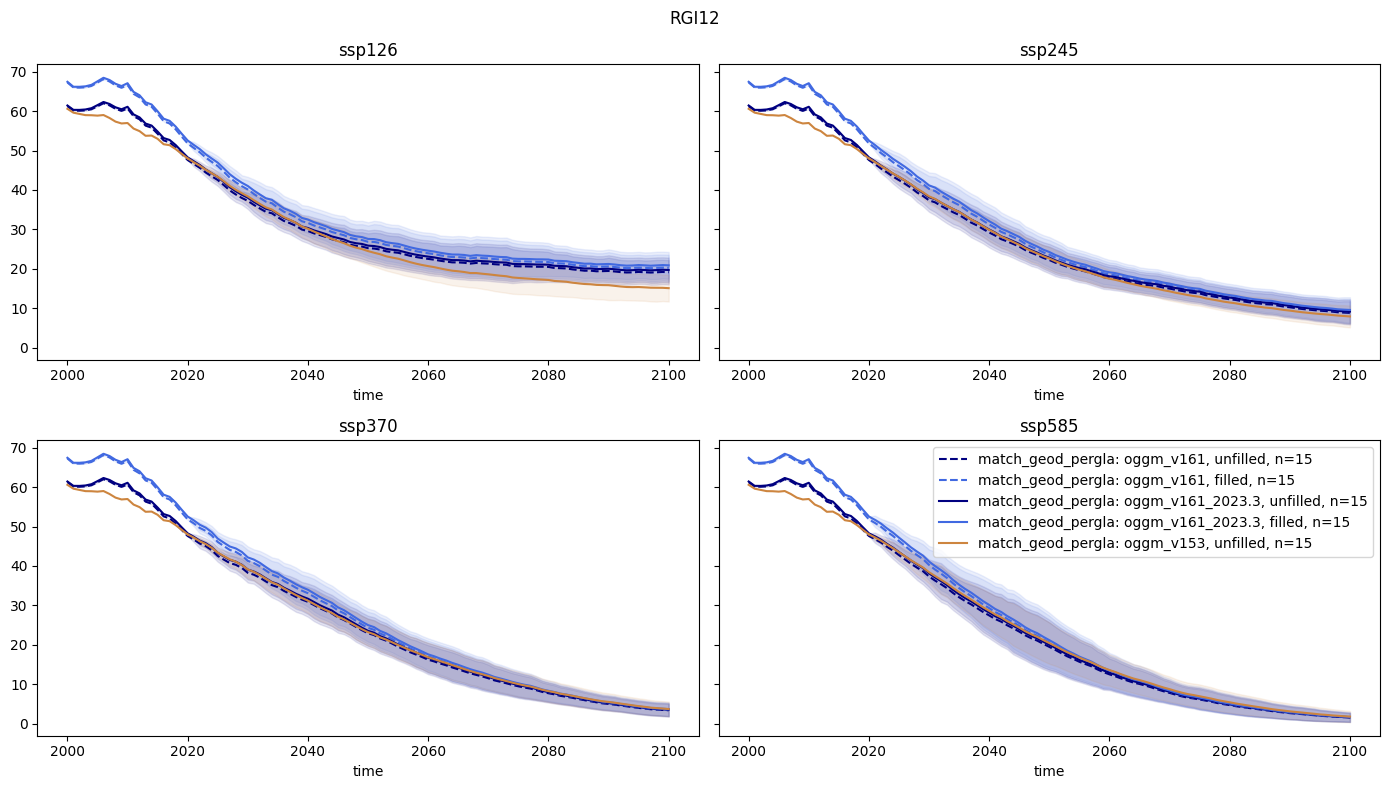

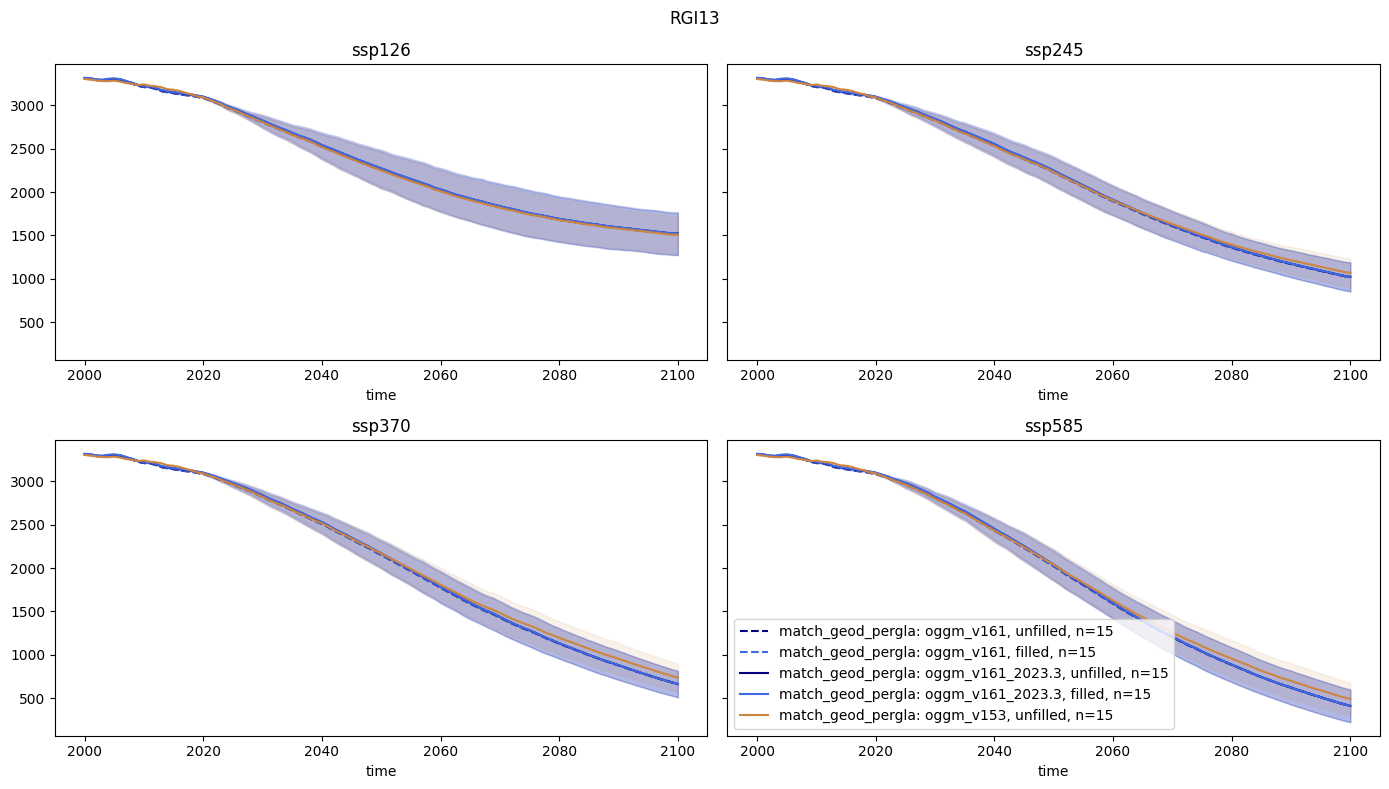

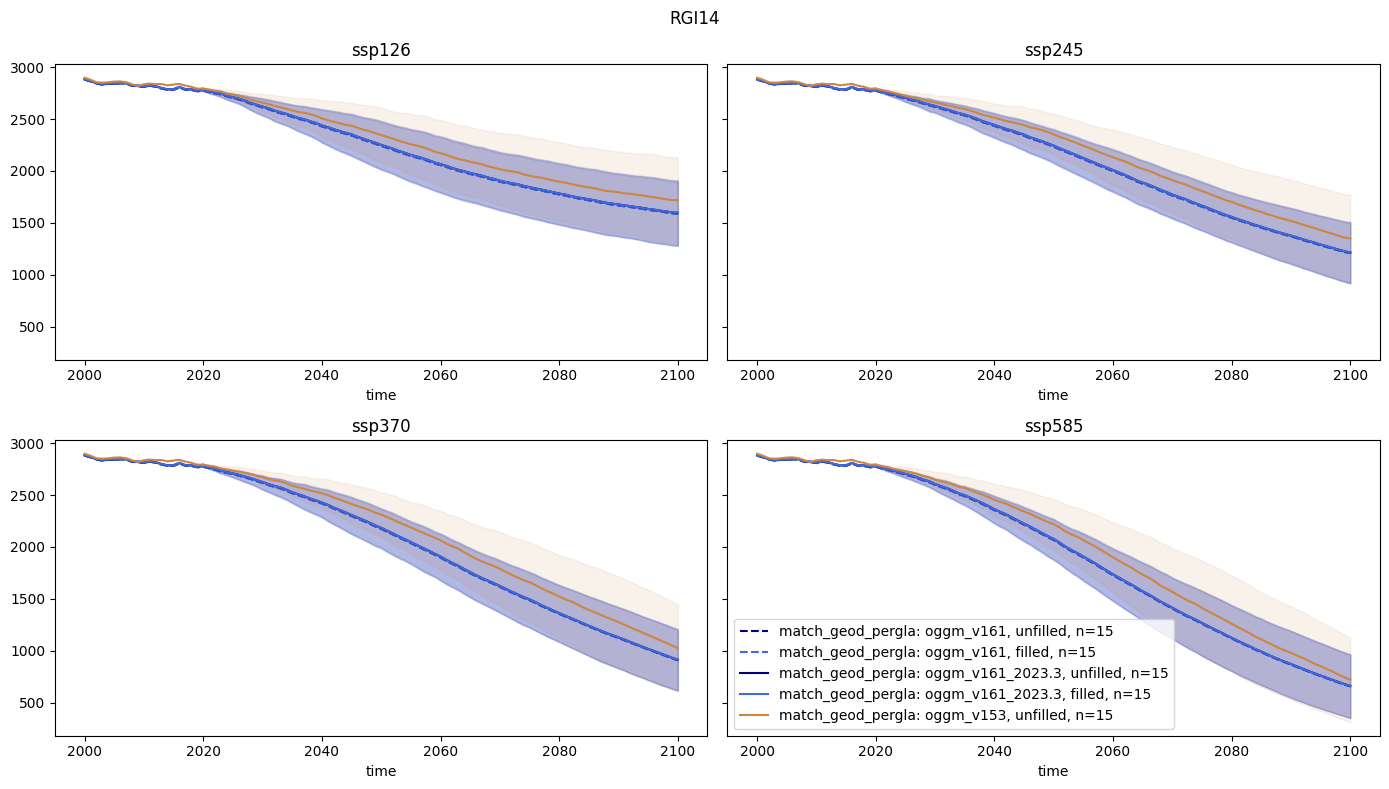

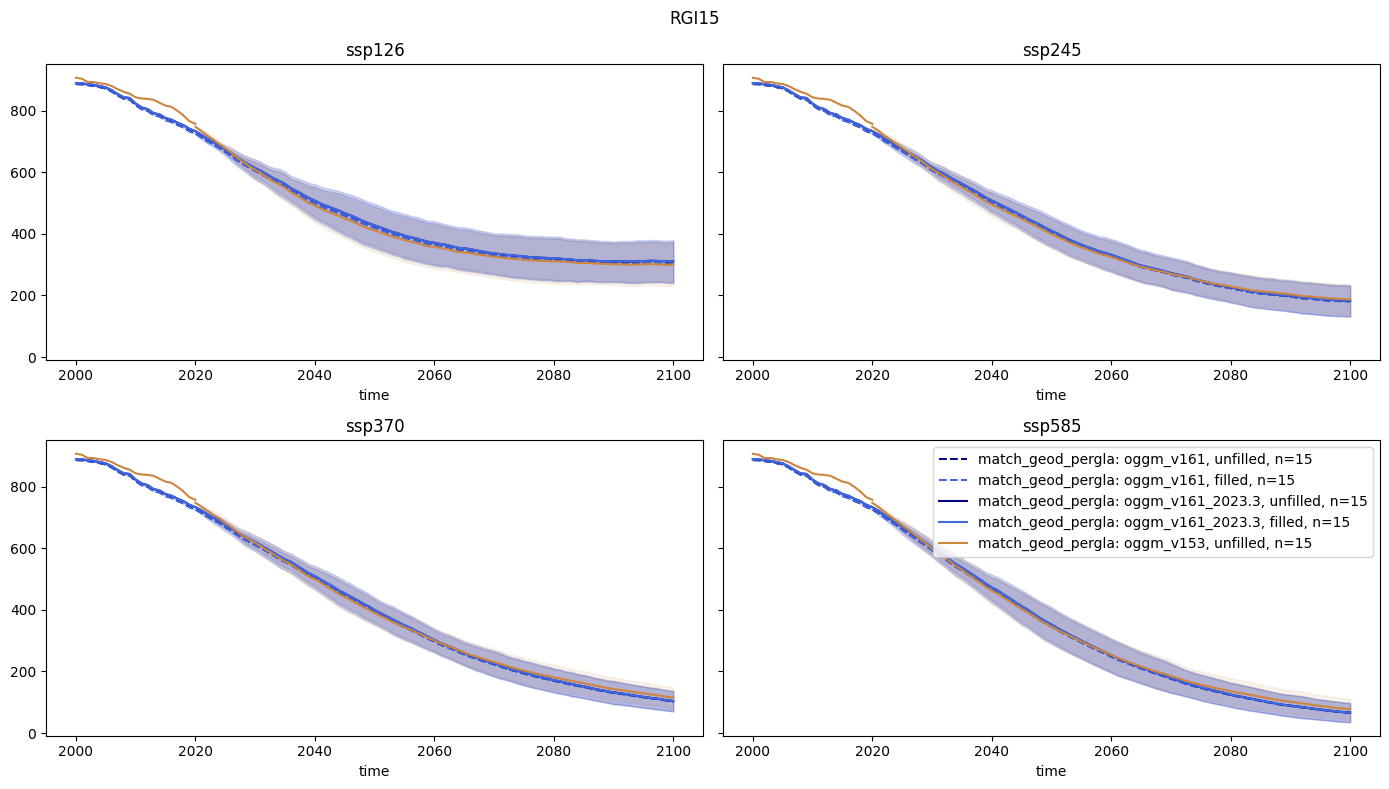

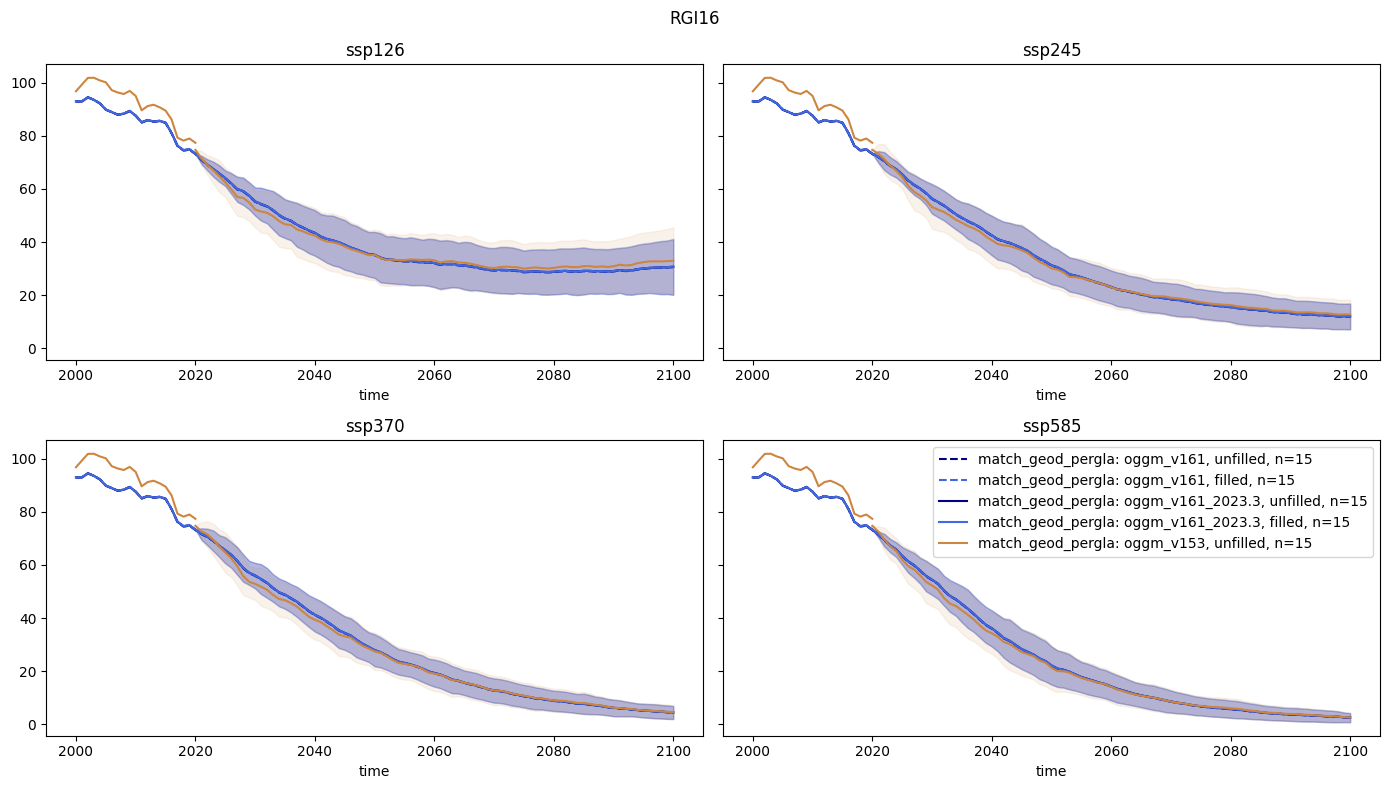

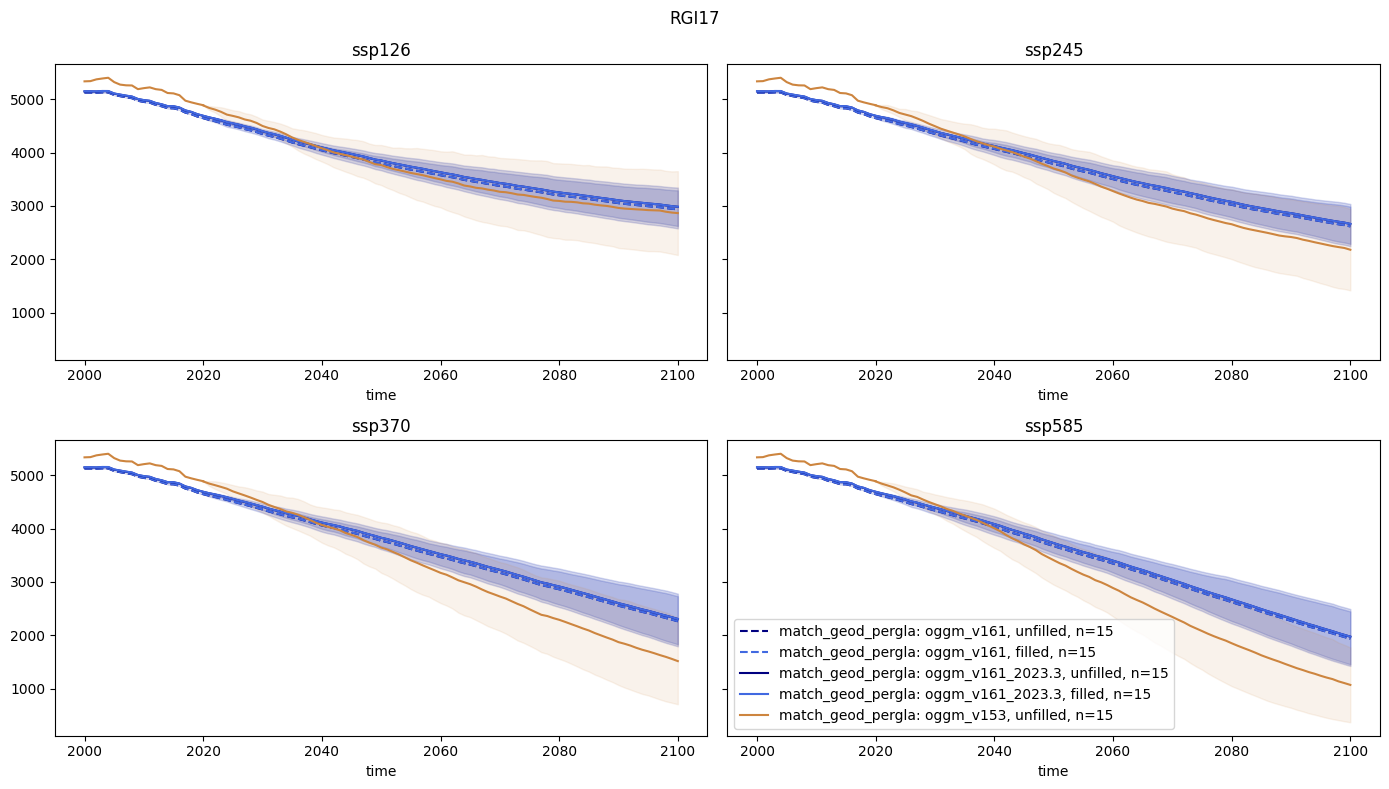

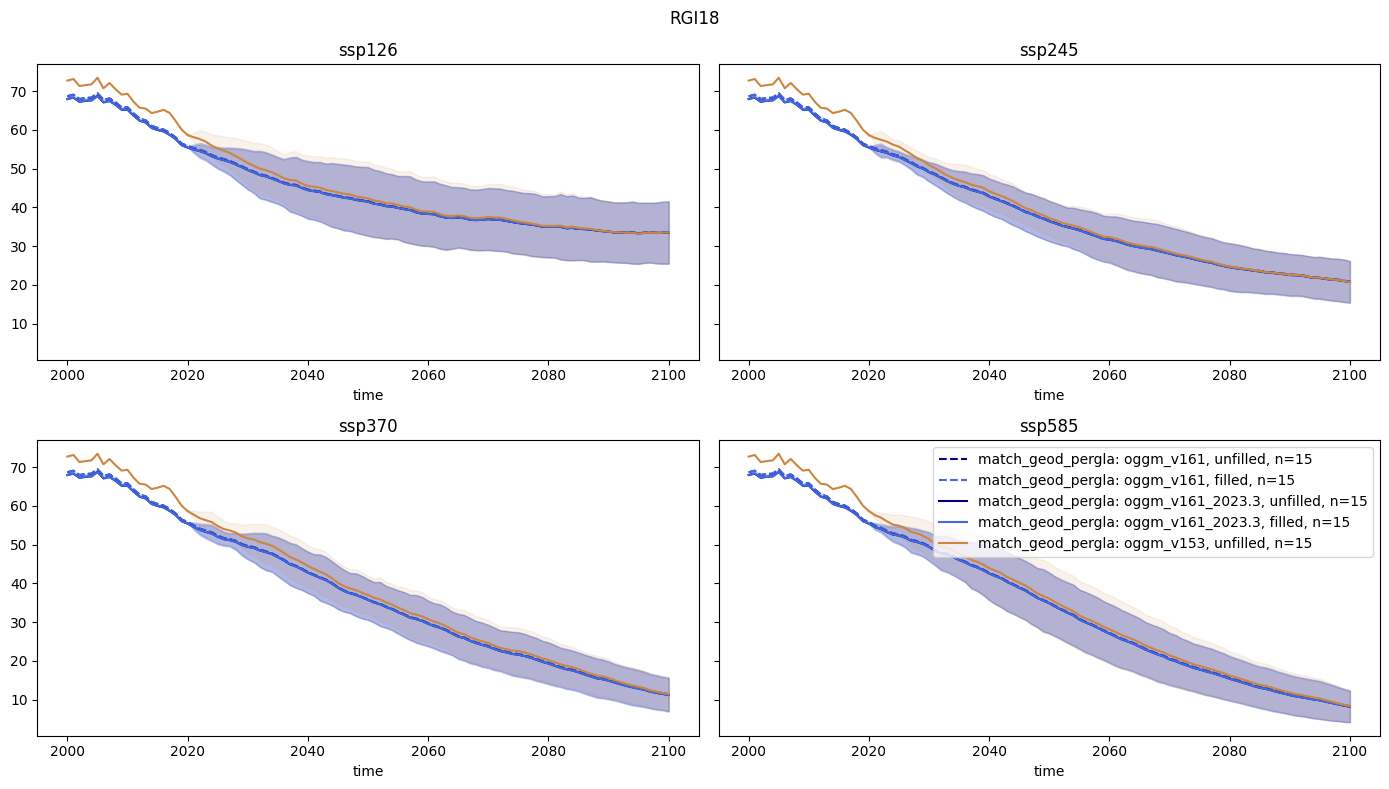

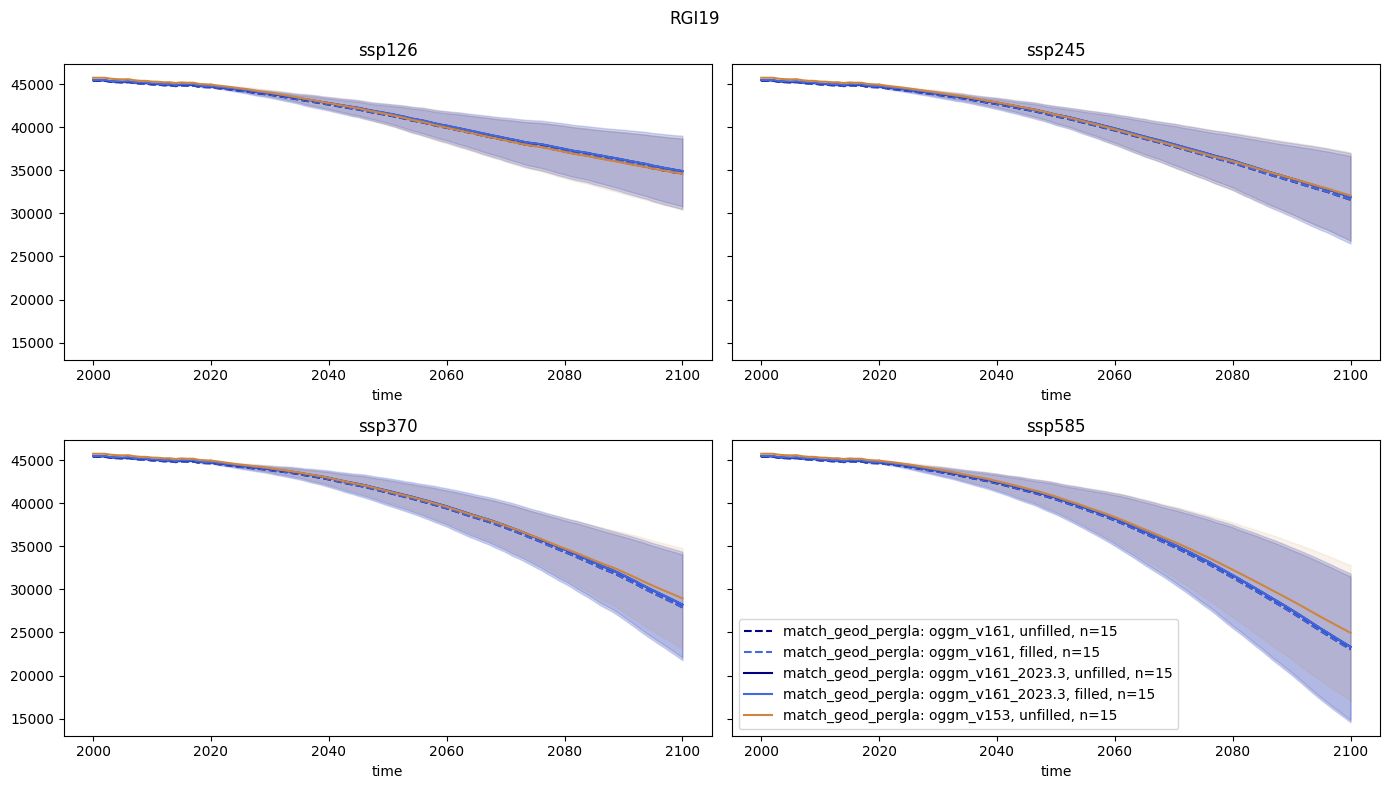

In [37]:
# plot per RGI region
for reg in sorted(df_meta.rgi_reg.unique()):
    f, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    axs = np.array(axs).flatten()
    for ssp, ax in zip(sorted(df_meta.ssp.unique())[1:], axs):
        for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
            
            for base_dir2, v in zip(['output_1.6.1/agg/', 'output_1.6.1_2023.3/agg/'],
                                    ['', '_2023.3']):
                if v == '':
                    ls = '--'
                else:
                    ls = '-'
                idir = base_dir2 + f'volume/{exp}/{reg}/'
                df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
                n = len(df.columns)
                avg = df.mean(axis=1) * 1e-9
                std = df.std(axis=1) * 1e-9
                ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color=c)
                avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, unfilled, n={n}', c=c,ls=ls);

                df = pd.read_csv(idir + f'/filled_{ssp}.csv', index_col=0)
                n_f = len(df.columns)
                avg = df.mean(axis=1) * 1e-9
                std = df.std(axis=1) * 1e-9
                ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color='royalblue')
                avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, filled, n={n_f}', c='royalblue', ls=ls);
            
            idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/agg/volume/{exp}/{reg}'
            df = pd.read_csv(idir_oggm_v153 + f'/{ssp}.csv', index_col=0)
            n_v153 = len(df.columns)
            avg = df.mean(axis=1) * 1e-9
            std = df.std(axis=1) * 1e-9
            ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color='peru')
            avg.plot(ax=ax, label=f'{exp}: oggm_v153, unfilled, n={n_v153}', c='peru');
            
            idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/historical/agg/volume/{exp}/'
            df = pd.read_csv(idir_oggm_v153 + f'historical.csv', index_col=0)[reg].loc[2000:]
            avg = df * 1e-9
            avg.plot(ax=ax, c='peru', label=f'{exp}: oggm_v153');
        ax.set_title(ssp)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:-1], labels[:-1]);
    plt.suptitle(reg)
    plt.tight_layout();

In [38]:
avg

time
2000.0    45728.076
2001.0    45727.682
2002.0    45727.087
2003.0    45612.918
2004.0    45564.297
2005.0    45538.624
2006.0    45561.520
2007.0    45438.867
2008.0    45372.475
2009.0    45366.670
2010.0    45281.220
2011.0    45266.940
2012.0    45203.876
2013.0    45206.716
2014.0    45114.626
2015.0    45186.504
2016.0    45147.564
2017.0    45153.290
2018.0    45009.605
2019.0    44970.640
2020.0    44934.020
Name: RGI19, dtype: float64

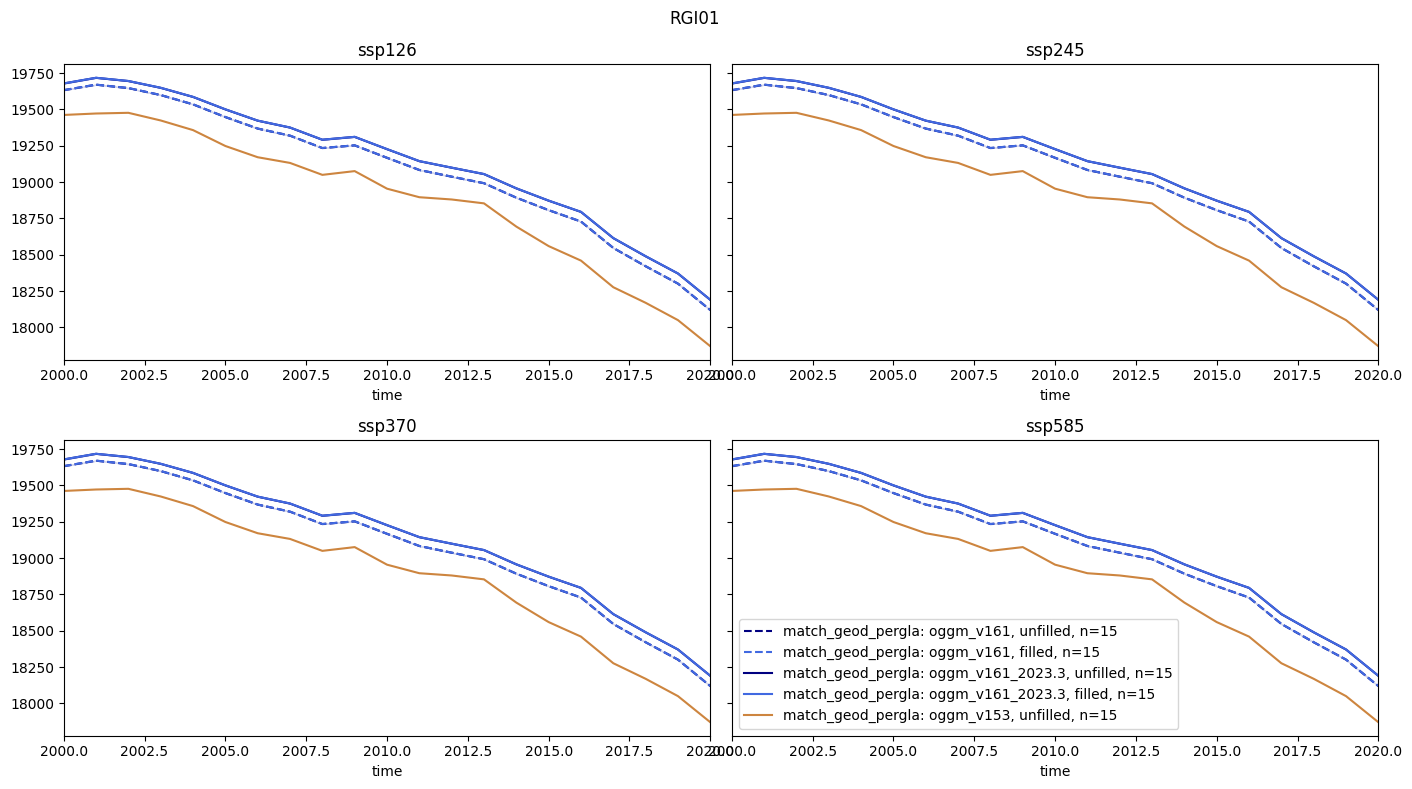

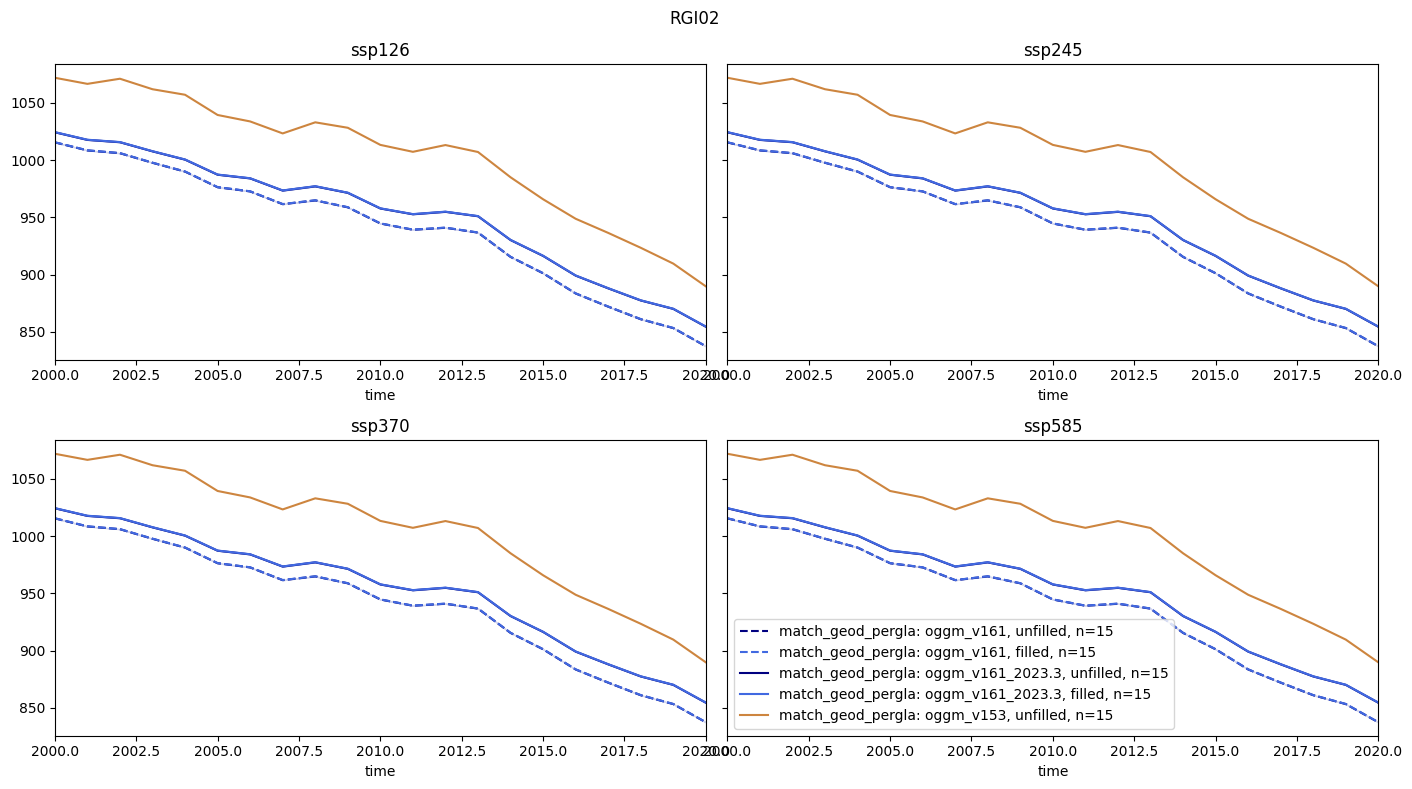

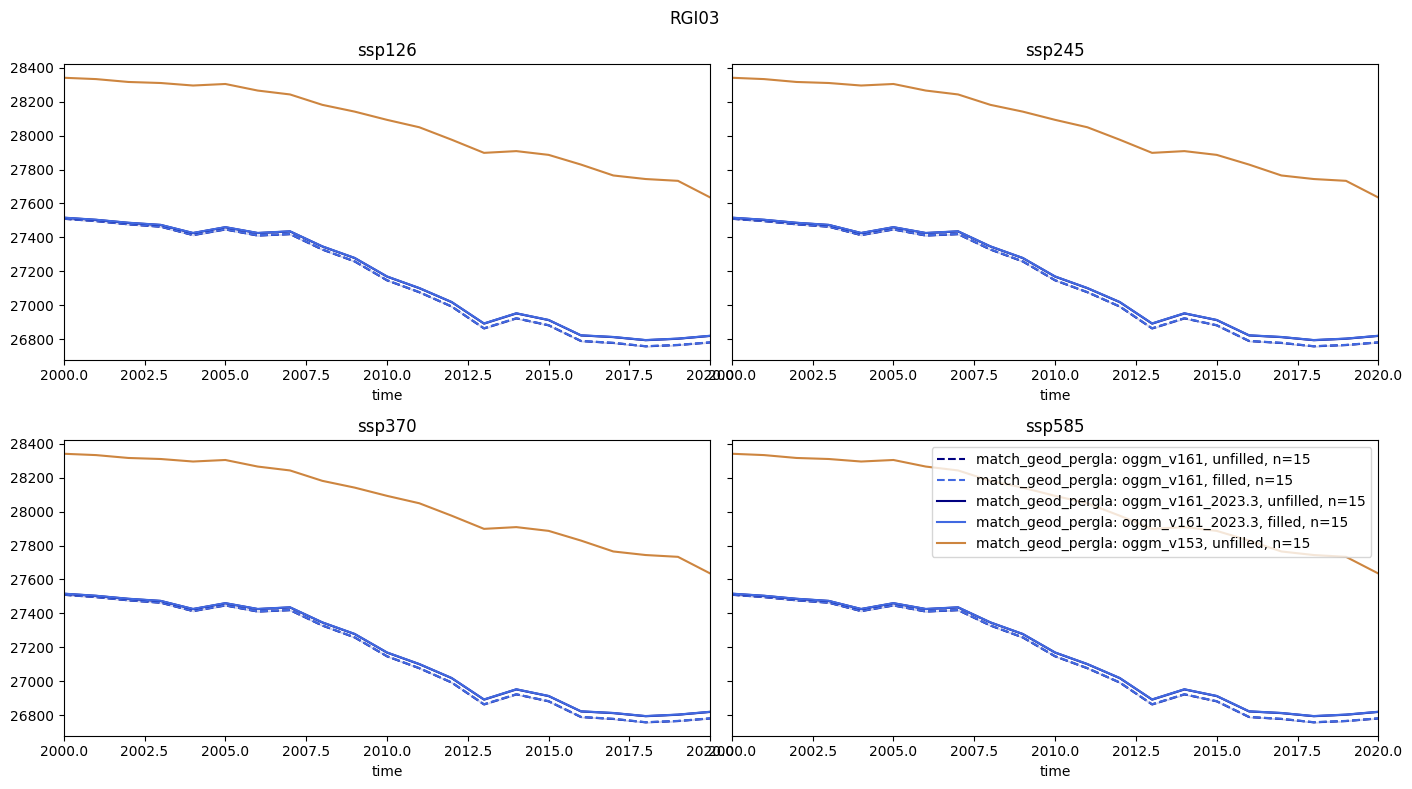

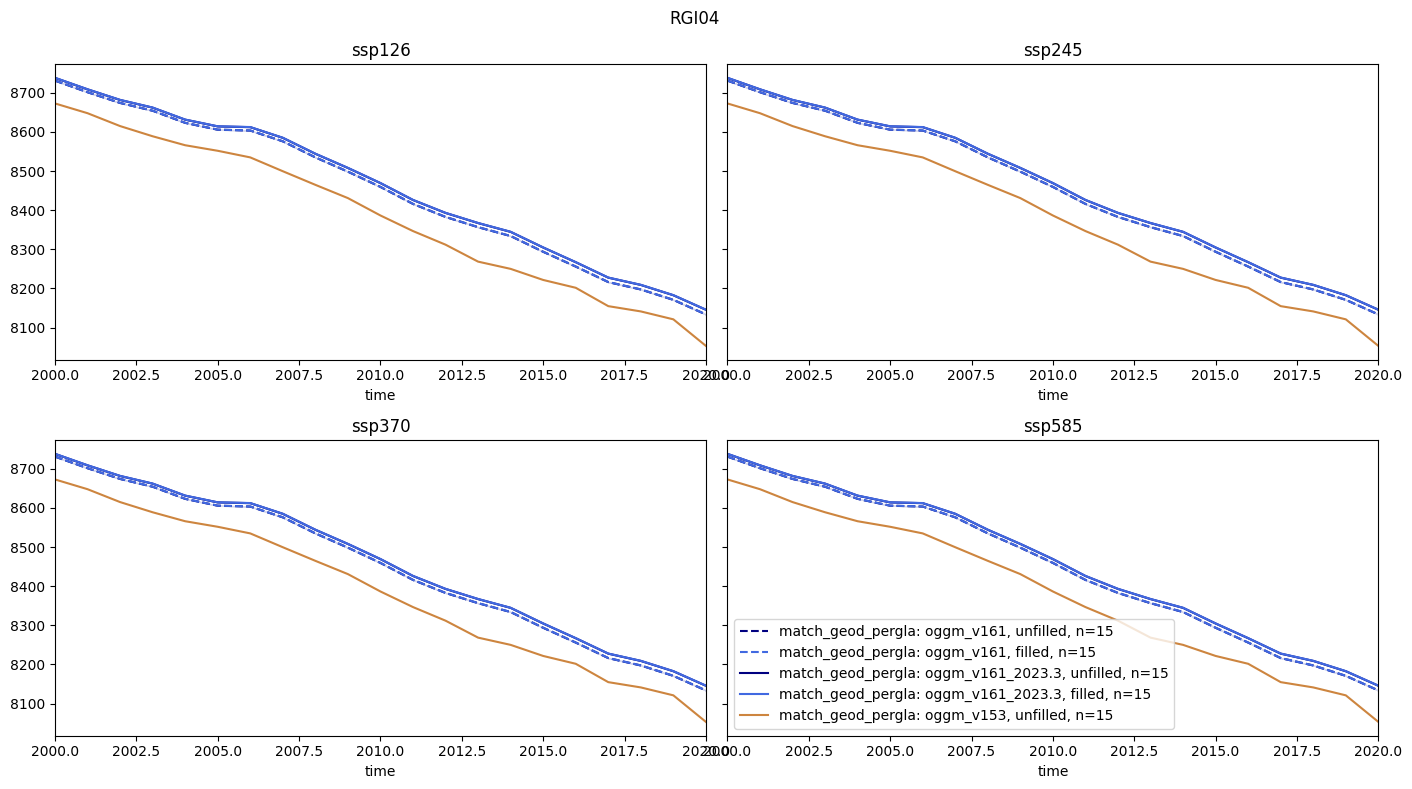

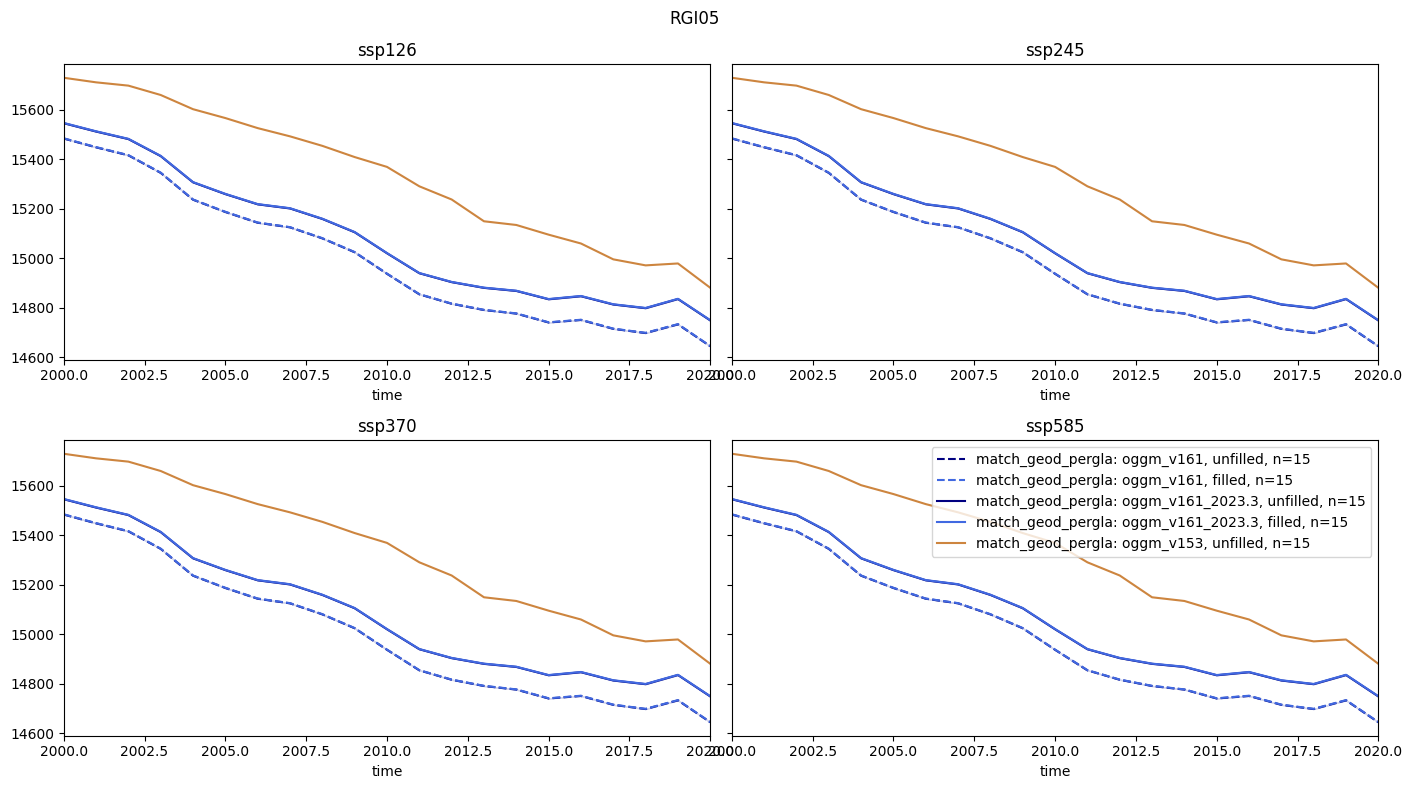

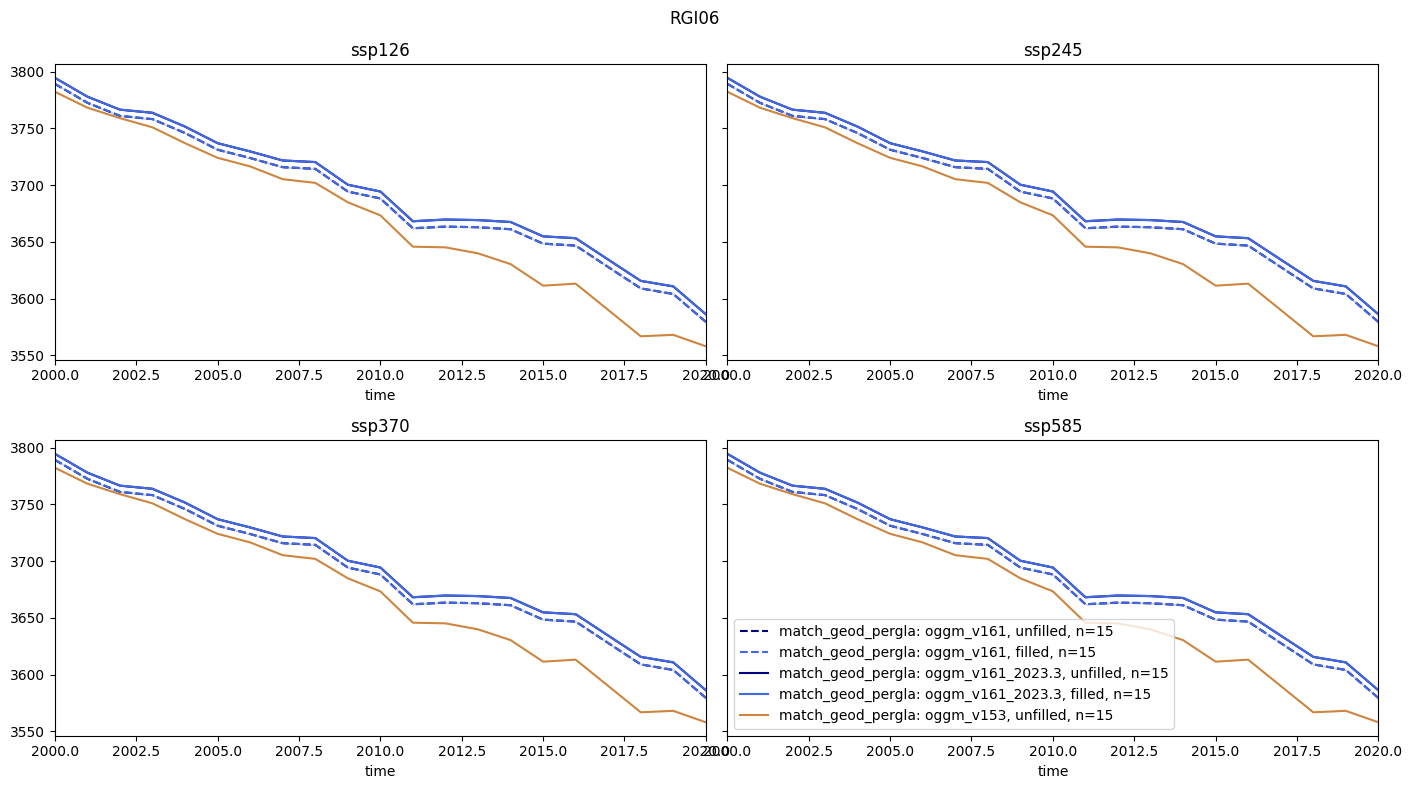

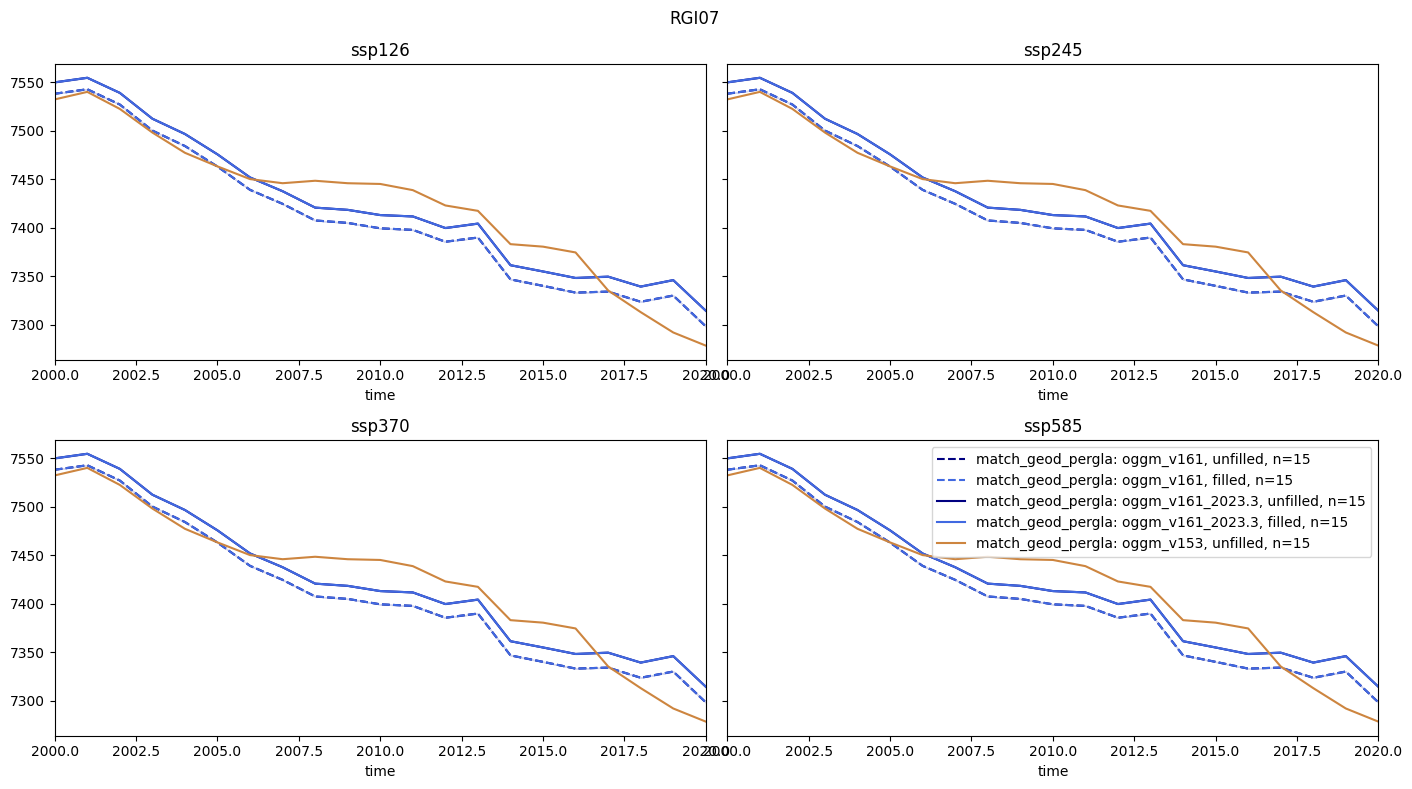

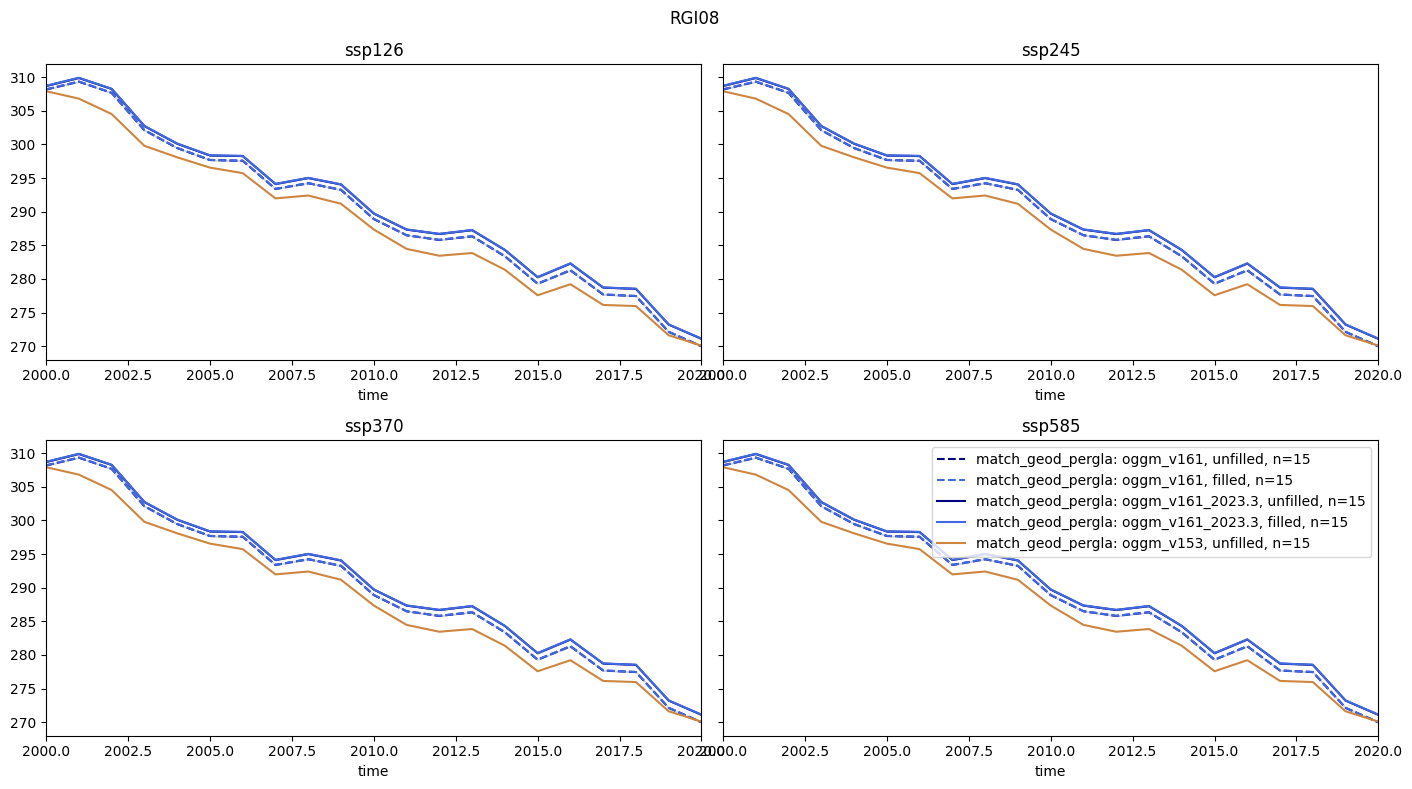

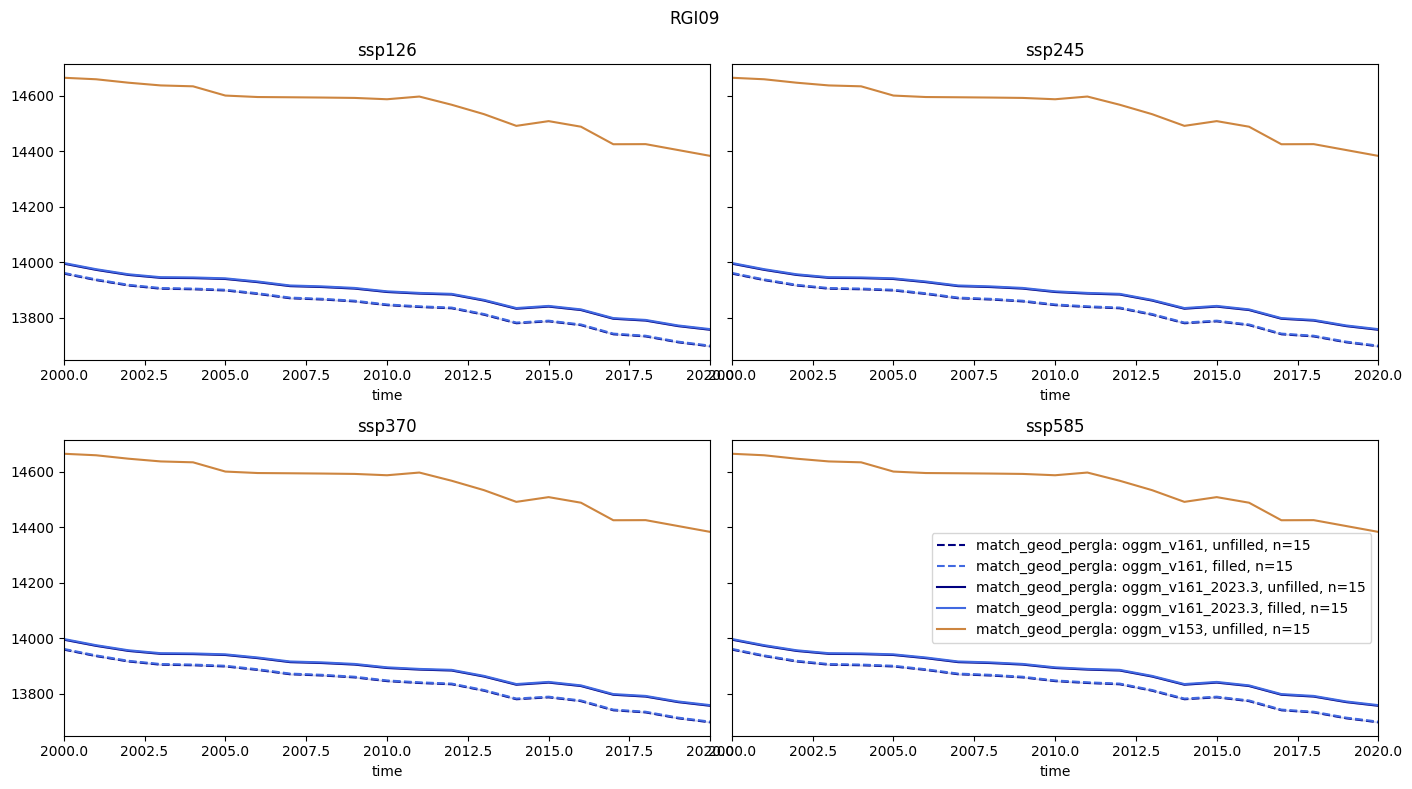

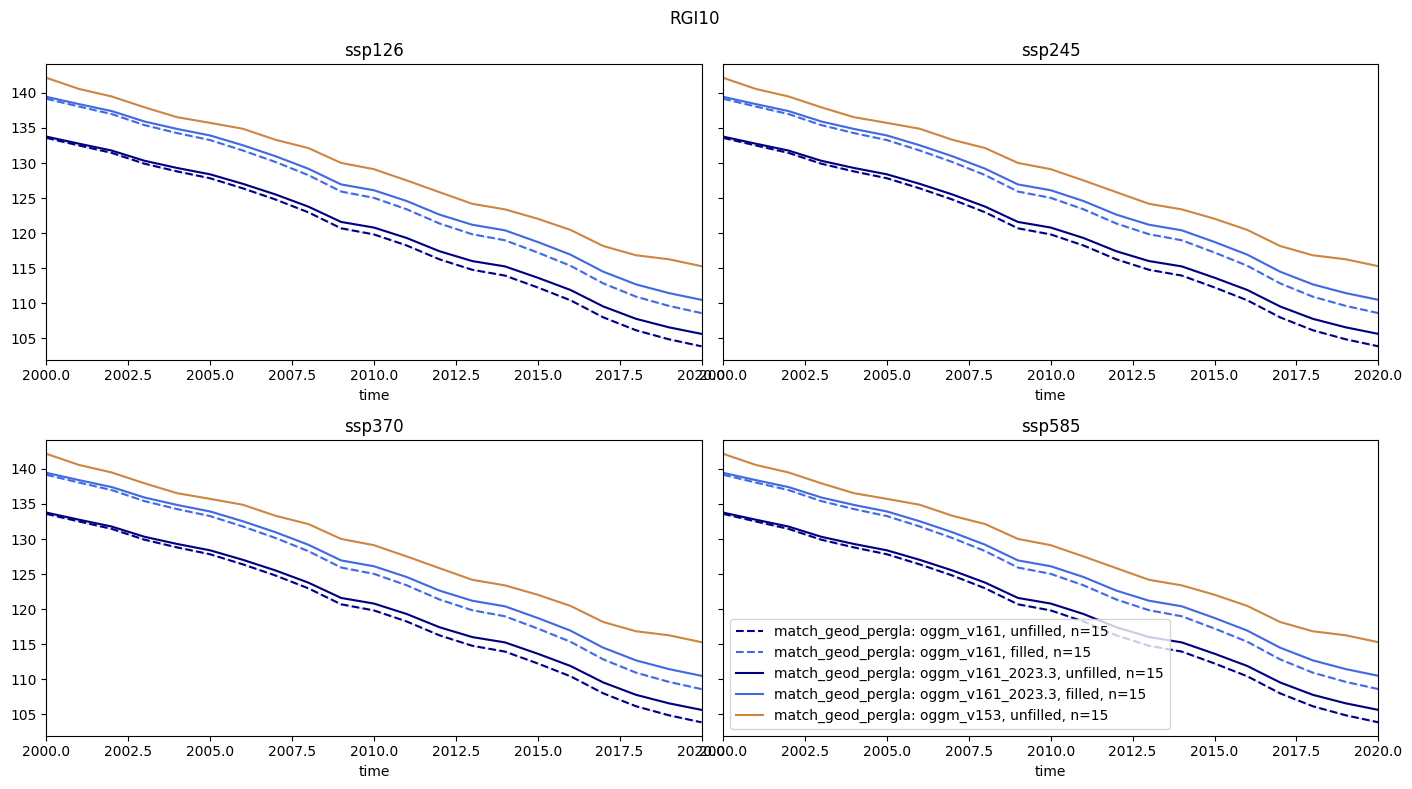

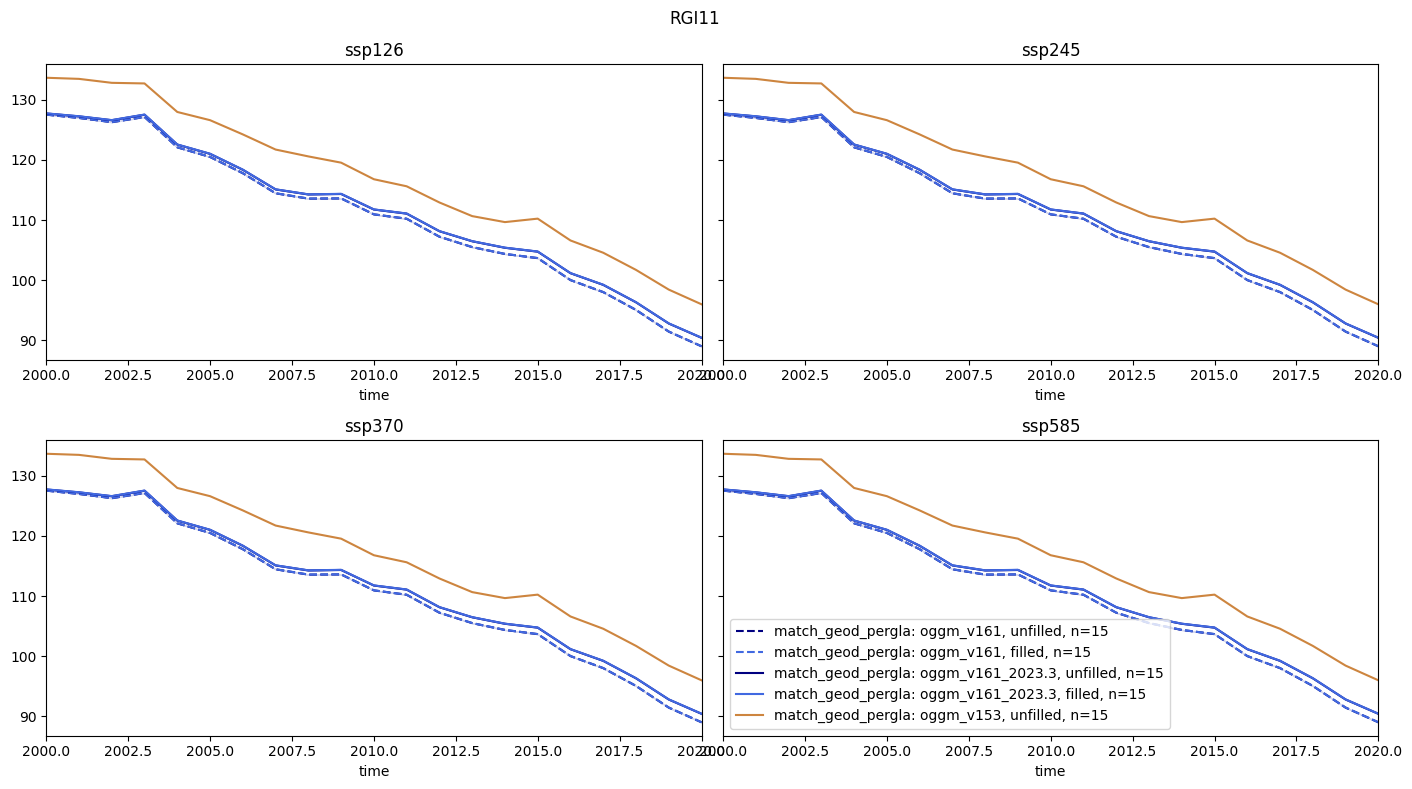

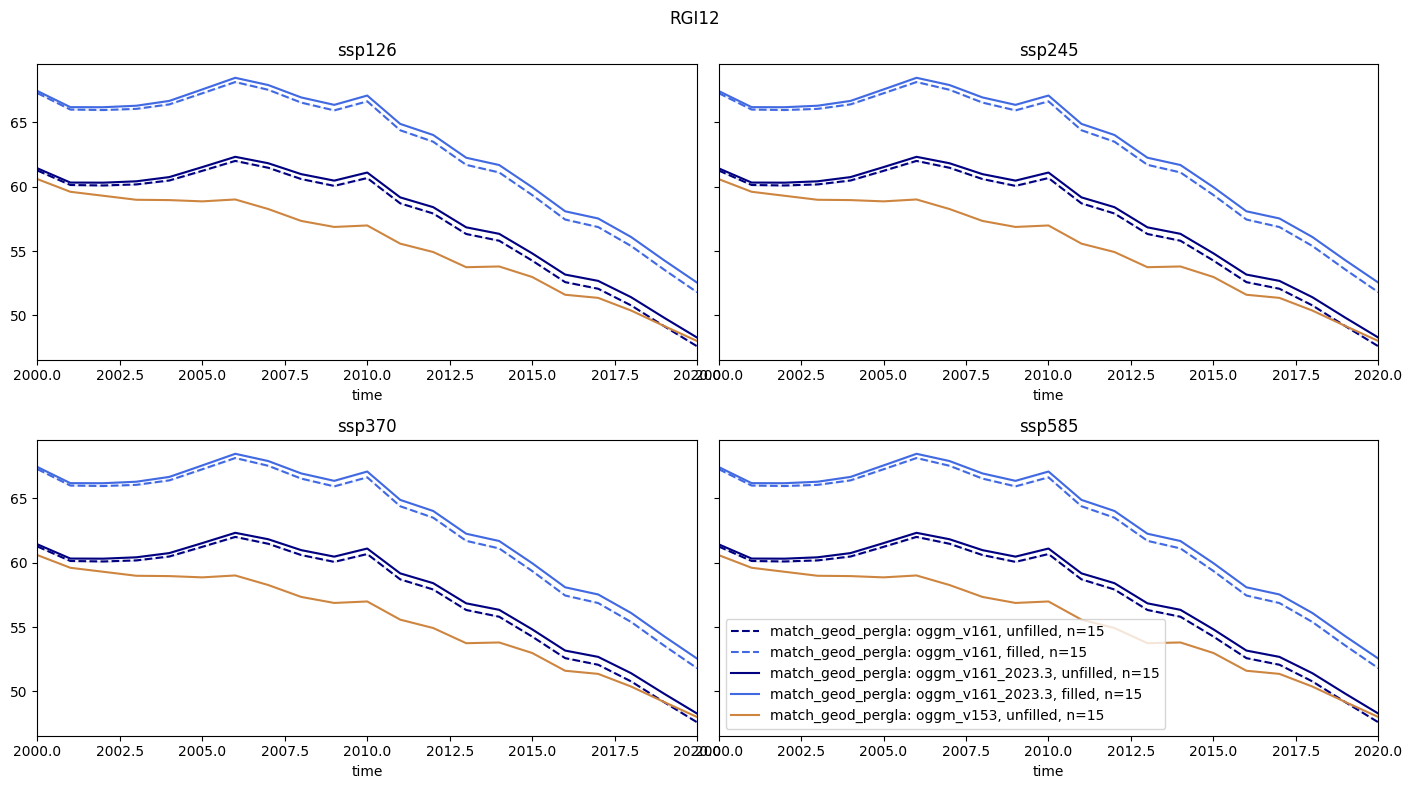

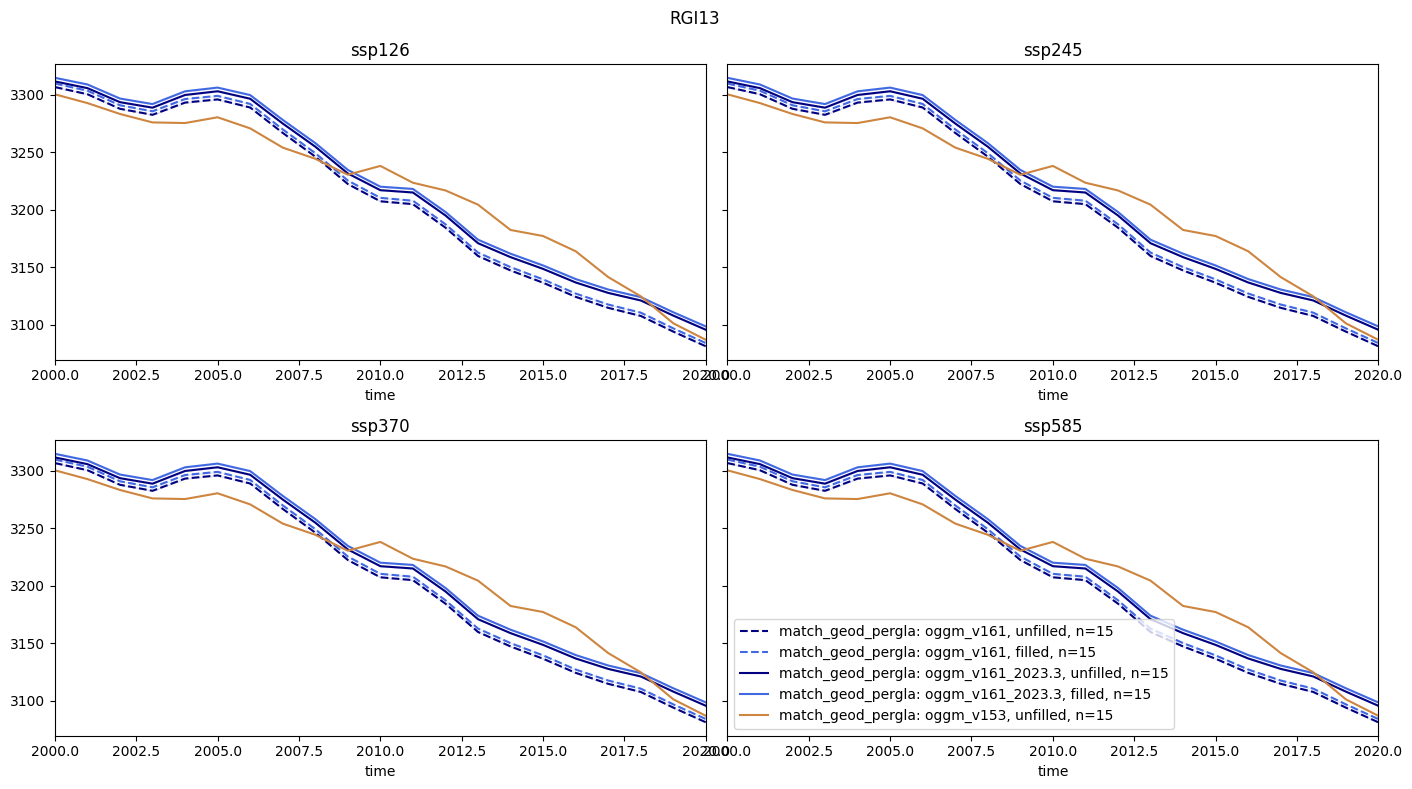

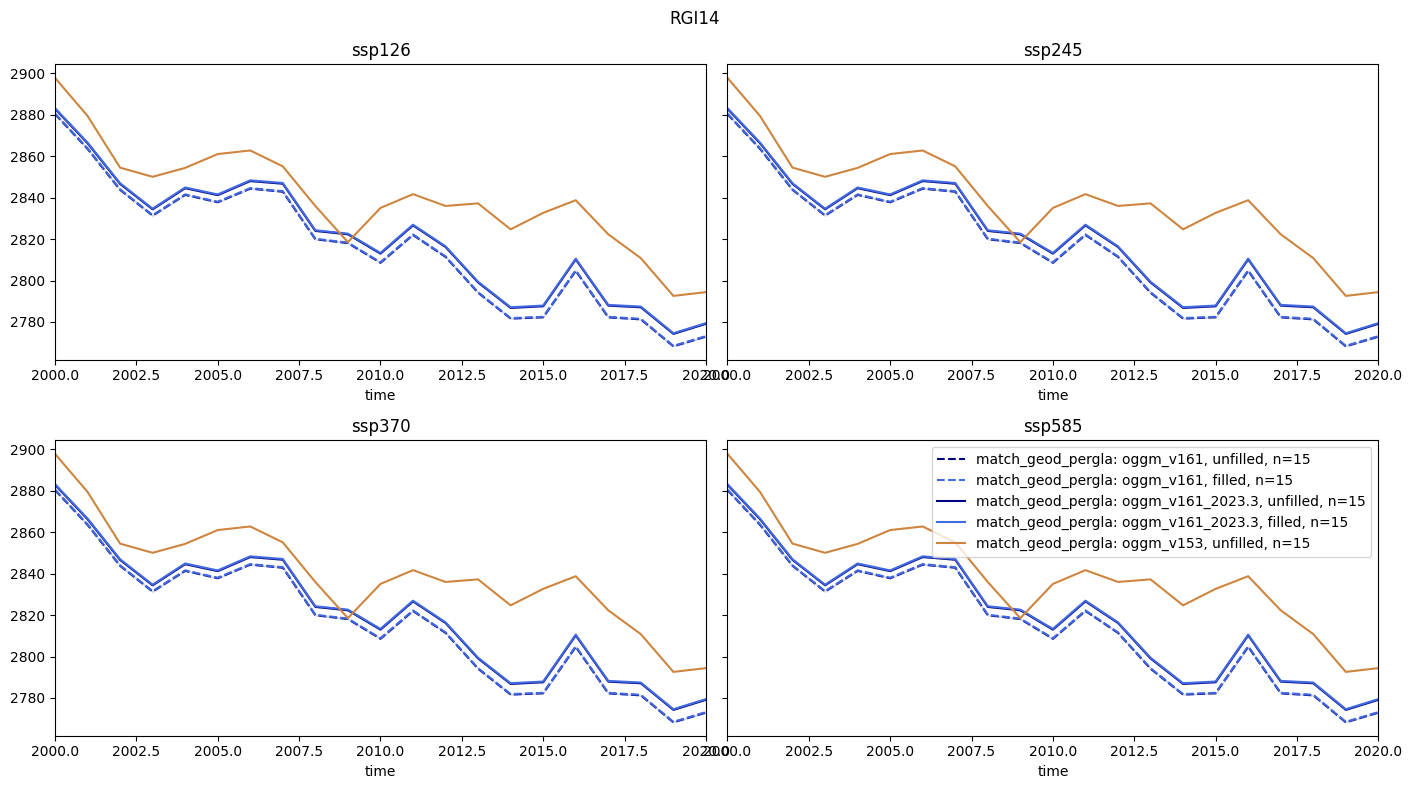

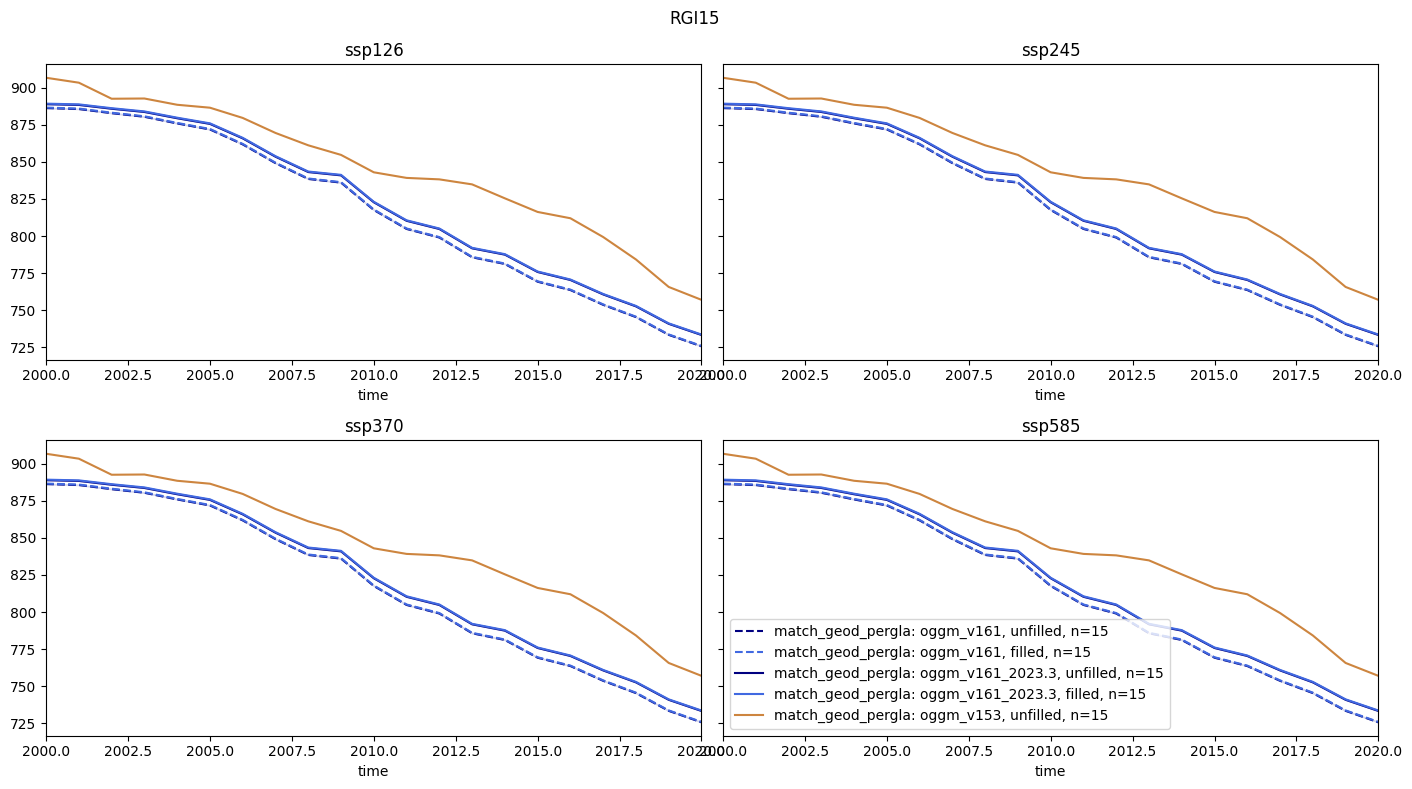

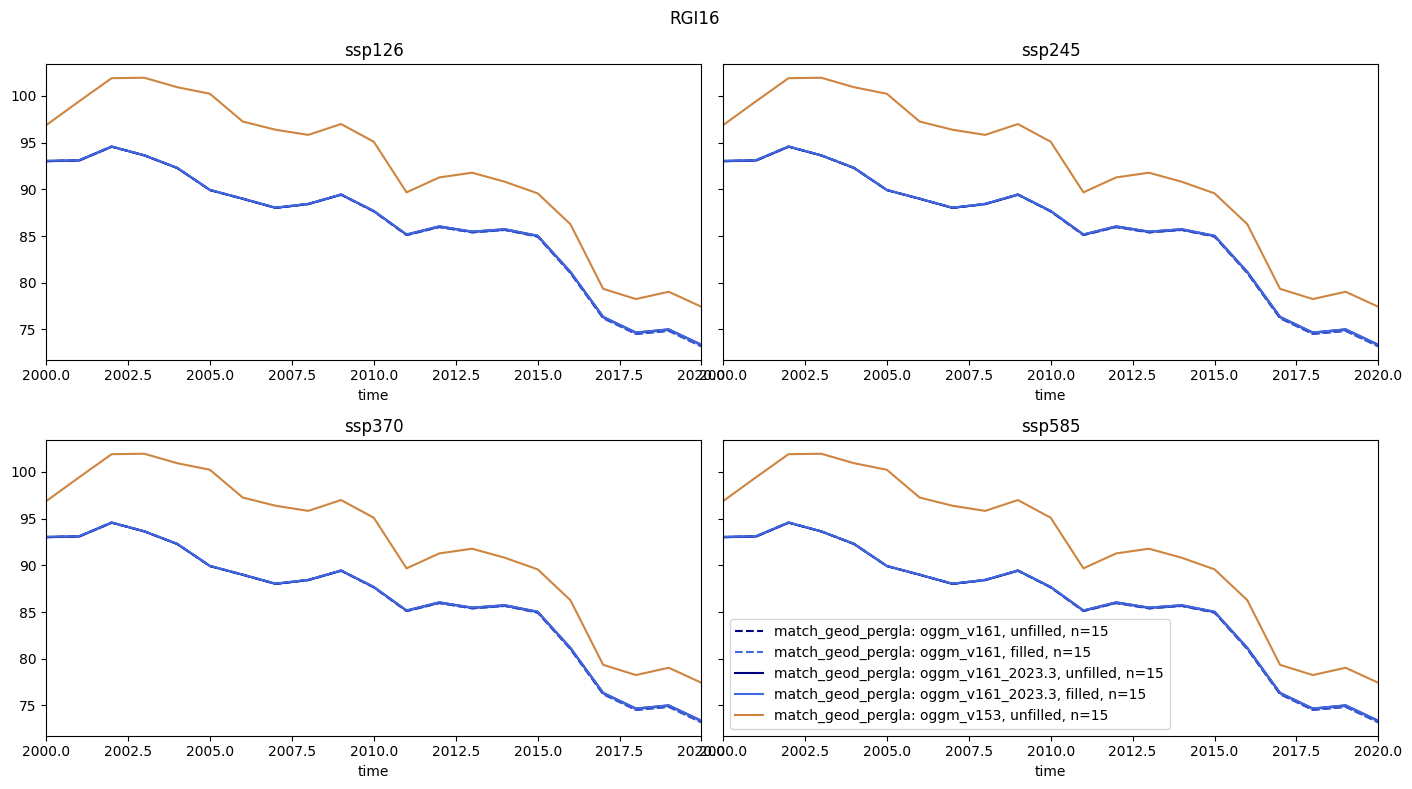

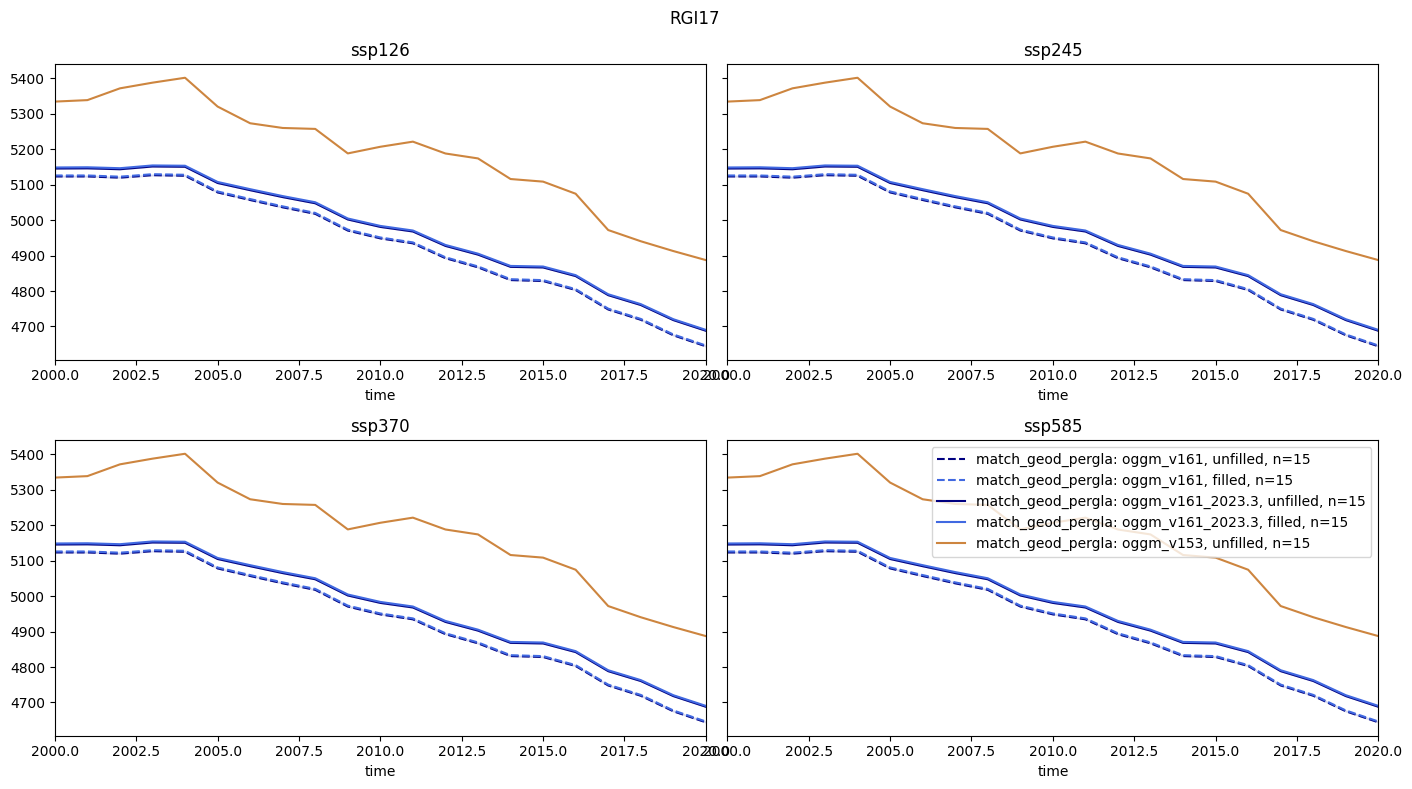

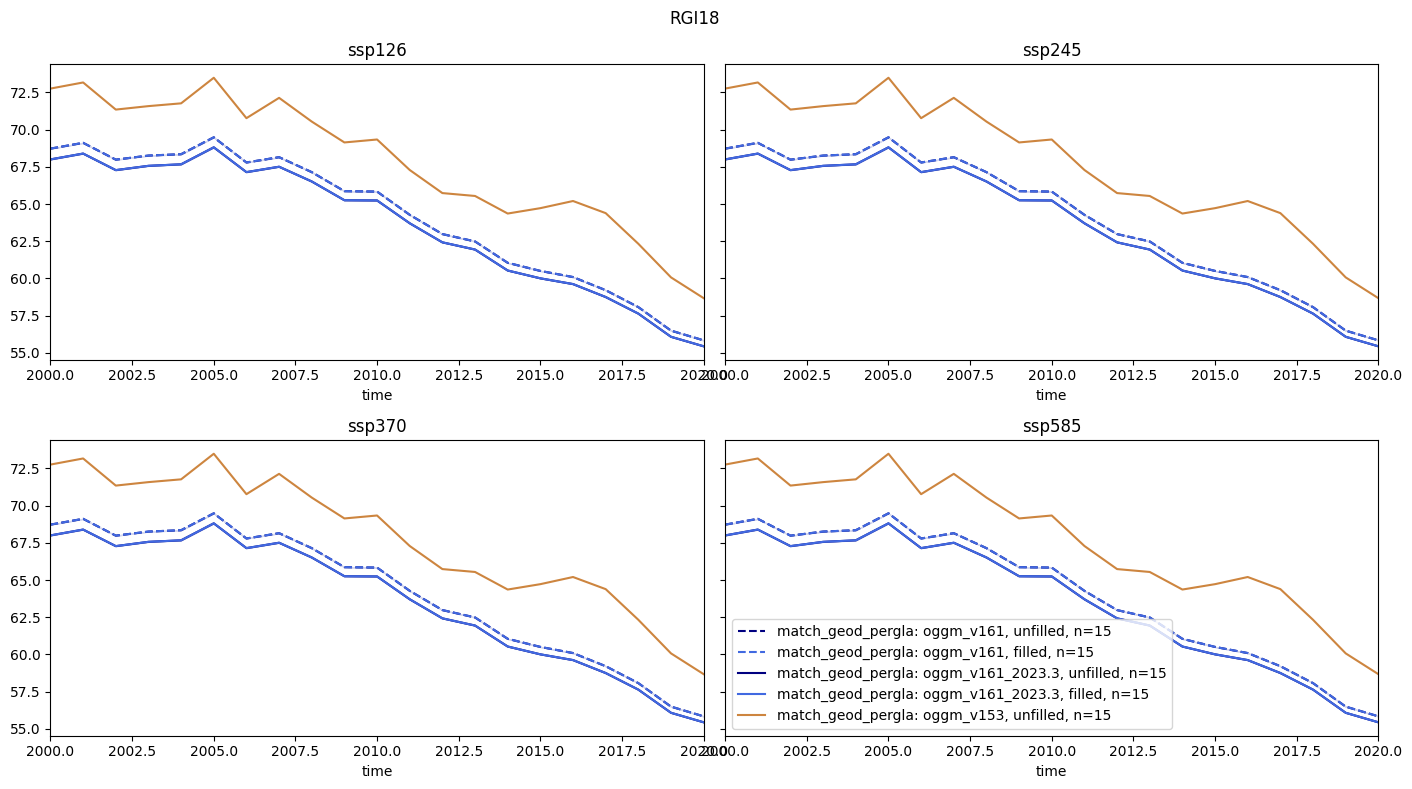

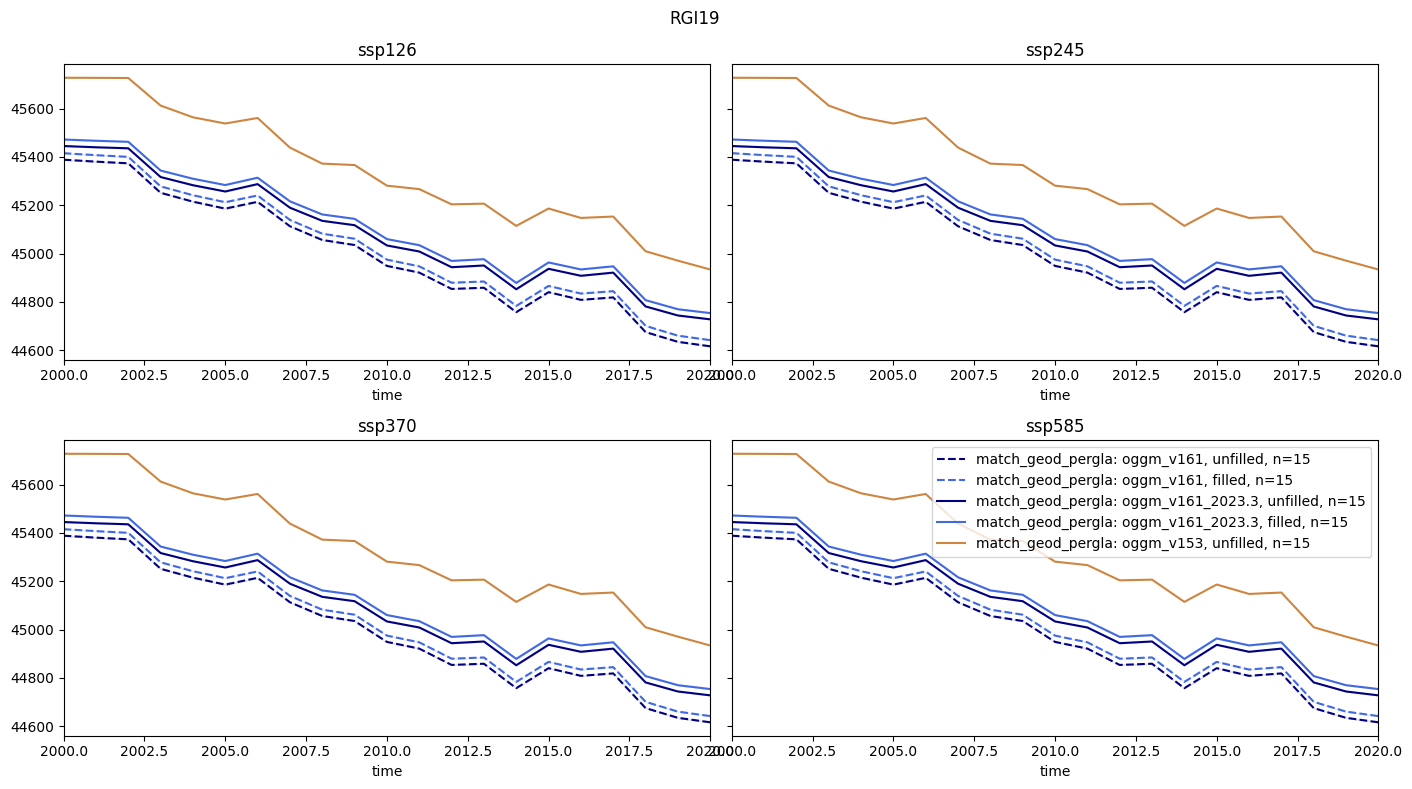

In [44]:
# plot per RGI region
for reg in sorted(df_meta.rgi_reg.unique()):
    f, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    axs = np.array(axs).flatten()
    for ssp, ax in zip(sorted(df_meta.ssp.unique())[1:], axs):
        for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
            
            for base_dir2, v in zip(['output_1.6.1/agg/', 'output_1.6.1_2023.3/agg/'],
                                    ['', '_2023.3']):
                if v == '':
                    ls = '--'
                else:
                    ls = '-'
                idir = base_dir2 + f'volume/{exp}/{reg}/'
                df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0).loc[2000:2020]
                n = len(df.columns)
                avg = df.mean(axis=1) * 1e-9
                std = df.std(axis=1) * 1e-9
                ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color=c)
                avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, unfilled, n={n}', c=c,ls=ls);

                df = pd.read_csv(idir + f'/filled_{ssp}.csv', index_col=0).loc[2000:2020]
                n_f = len(df.columns)
                avg = df.mean(axis=1) * 1e-9
                std = df.std(axis=1) * 1e-9
                ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color='royalblue')
                avg.plot(ax=ax, label=f'{exp}: oggm_v161{v}, filled, n={n_f}', c='royalblue', ls=ls);
            
            idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/agg/volume/{exp}/{reg}'
            df = pd.read_csv(idir_oggm_v153 + f'/{ssp}.csv', index_col=0).loc[2000:2020]
            n_v153 = len(df.columns)
            avg = df.mean(axis=1) * 1e-9
            std = df.std(axis=1) * 1e-9
            ax.fill_between(avg.index, avg-std, avg+std, alpha=0.1, color='peru')
            avg.plot(ax=ax, label=f'{exp}: oggm_v153, unfilled, n={n_v153}', c='peru');
            
            idir_oggm_v153 = f'/home/www/fmaussion/runs/runs_diff_calib_protect/historical/agg/volume/{exp}/'
            df = pd.read_csv(idir_oggm_v153 + f'historical.csv', index_col=0)[reg].loc[2000:2020]
            avg = df * 1e-9
            avg.plot(ax=ax, c='peru', label=f'{exp}: oggm_v153');
        ax.set_title(ssp)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:-1], labels[:-1]);
    plt.suptitle(reg)
    plt.tight_layout();
    for ax in axs:
        ax.set_xlim([2000,2020])